# Import the packages and libraries

In [1]:
import pandas as pd
pd.options.display.max_columns=60

import numpy as np
import sys

import statsmodels.tsa.statespace as sts

from matplotlib import style
style.use('ggplot')

import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.tsa.arima_process as sta
import statsmodels.graphics.tsaplots as sgt
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf

from util_formula import *


/home/zhou/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


# 0- reading data and summary statistics

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/kevinzous/Forecasting-Projects-/master/Project%202/data/P2train.csv', parse_dates=['Time'],index_col='Time',header=0)
test = pd.read_csv('https://raw.githubusercontent.com/kevinzous/Forecasting-Projects-/master/Project%202/data/P2test.csv', parse_dates=['Time'],index_col='Time',header=0)
test_index = pd.read_csv('https://raw.githubusercontent.com/kevinzous/Forecasting-Projects-/master/Project%202/data/P2test_index.csv', header=0)


In [3]:
print(train.shape)
print(train.columns)
print(train.dtypes)
train.head(10)

train.describe()
#Outliers spot : max rainfall 9m/h temperature 0 K 

#The highest recorded rainfall in a single year was 22,987 mm (904.9 in) in 1861. The 38-year average at Mawsynram, Meghalaya, India is 11,873 mm (467.4 in).
train[train.Temp<200]  #2014-01-31 to 2014-02-02  
# if <200 <=> <-75 °C then put mean(n-1,n+1)
train[train.TrafficVolume<10]
train[train.Rain1h>2000]  #2016-07-11 17:00:00  here around = 0
#if >2000 then put mean (n-1,n+1)

(40000, 8)
Index(['IsHoliday', 'Temp', 'Rain1h', 'Snow1h', 'CloudsAll', 'WeatherMain',
       'WeatherDescription', 'TrafficVolume'],
      dtype='object')
IsHoliday              object
Temp                  float64
Rain1h                float64
Snow1h                float64
CloudsAll               int64
WeatherMain            object
WeatherDescription     object
TrafficVolume           int64
dtype: object


IsHoliday    Temp  Rain1h  Snow1h  CloudsAll WeatherMain  \
Time                                                                           
2016-07-11 17:00:00      None  302.11  9831.3     0.0         75        Rain   

                    WeatherDescription  TrafficVolume  
Time                                                   
2016-07-11 17:00:00    very heavy rain           5535

## Exploration of the data

/home/zhou/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


IsHoliday    Temp  Rain1h  Snow1h  CloudsAll WeatherMain  \
Time                                                                           
2017-03-09 00:00:00      None  271.00     0.0     0.0         90      Clouds   
2017-03-09 01:00:00      None  270.66     0.0     0.0         90      Clouds   
2017-03-09 02:00:00      None  270.34     0.0     0.0         40      Clouds   
2017-03-09 03:00:00      None  270.00     0.0     0.0          1       Clear   
2017-03-09 04:00:00      None  269.35     0.0     0.0          1       Clear   
2017-03-09 05:00:00      None  269.19     0.0     0.0          1       Clear   
2017-03-09 06:00:00      None  268.46     0.0     0.0         90      Clouds   
2017-03-09 07:00:00      None  268.00     0.0     0.0         90      Clouds   
2017-03-09 08:00:00      None  268.14     0.0     0.0         90      Clouds   
2017-03-09 09:00:00      None  268.71     0.0     0.0         90      Clouds   
2017-03-09 10:00:00      None  269.15     0.0     0.0          1       Clear   
2017-03-09 11:00:00      None  270.08     0.0     0.0          1       Clear   
2017-03-09 12:00:00      None  271.02     0.0     0.0         40      Clouds   
2017-03-09 13:00:00      None  270.82     0.0     0.0          1       Clear   
2017-03-09 14:00:00      None  271.01     0.0     0.0         90      Clouds   
2017-03-09 15:00:00      None  270.78     0.0     0.0         90      Clouds   
2017-03-09 16:00:00      None  270.75     0.0     0.0         90      Clouds   
2017-03-09 17:00:00      None  270.62     0.0     0.0         90      Clouds   
2017-03-09 18:00:00      None  270.23     0.0     0.0         40      Clouds   
2017-03-09 19:00:00      None  269.16     0.0     0.0         40      Clouds   
2017-03-09 20:00:00      None  268.22     0.0     0.0          1       Clear   
2017-03-09 21:00:00      None  267.56     0.0     0.0          5       Clear   
2017-03-09 22:00:00      None  266.82     0.0     0.0          1       Clear   
2017-03-09 23:00:00      None  266.03     0.0     0.0          1       Clear   

                    WeatherDescription  TrafficVolume  
Time                                                   
2017-03-09 00:00:00    overcast clouds            569  
2017-03-09 01:00:00    overcast clouds            364  
2017-03-09 02:00:00   scattered clouds            271  
2017-03-09 03:00:00       sky is clear            322  
2017-03-09 04:00:00       sky is clear            830  
2017-03-09 05:00:00       sky is clear           3166  
2017-03-09 06:00:00    overcast clouds           6236  
2017-03-09 07:00:00    overcast clouds           6928  
2017-03-09 08:00:00    overcast clouds           6327  
2017-03-09 09:00:00    overcast clouds           5226  
2017-03-09 10:00:00       sky is clear           4594  
2017-03-09 11:00:00       sky is clear           5068  
2017-03-09 12:00:00   scattered clouds           5254  
2017-03-09 13:00:00       sky is clear           5278  
2017-03-09 14:00:00    overcast clouds           5599  
2017-03-09 15:00:00    overcast clouds           5929  
2017-03-09 16:00:00    overcast clouds           7280  
2017-03-09 17:00:00    overcast clouds           6453  
2017-03-09 18:00:00   scattered clouds           4672  
2017-03-09 19:00:00   scattered clouds           3494  
2017-03-09 20:00:00       sky is clear           3628  
2017-03-09 21:00:00       sky is clear           3124  
2017-03-09 22:00:00       sky is clear           2820  
2017-03-09 23:00:00       sky is clear           2218

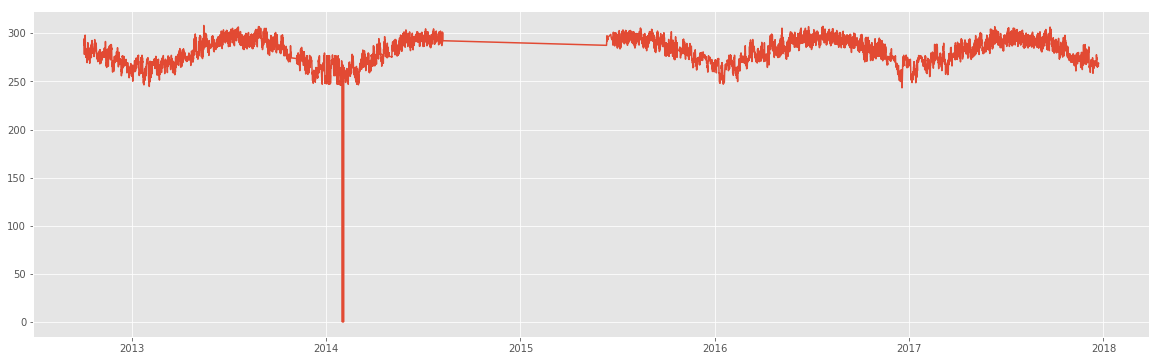

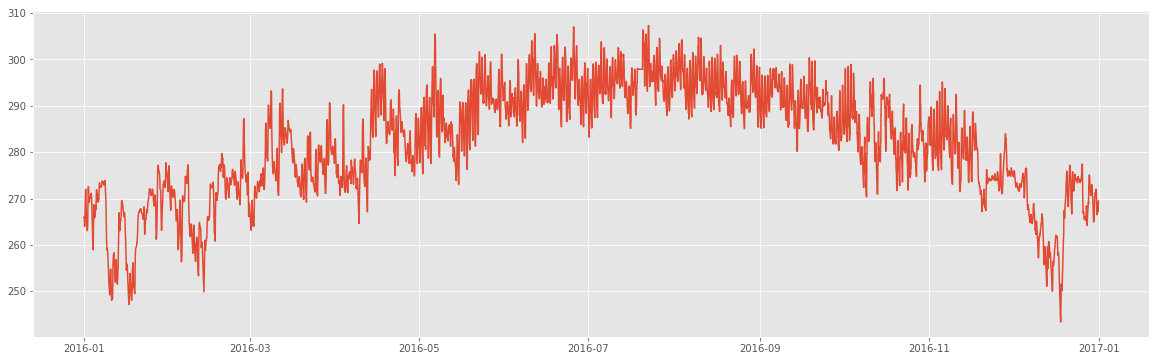

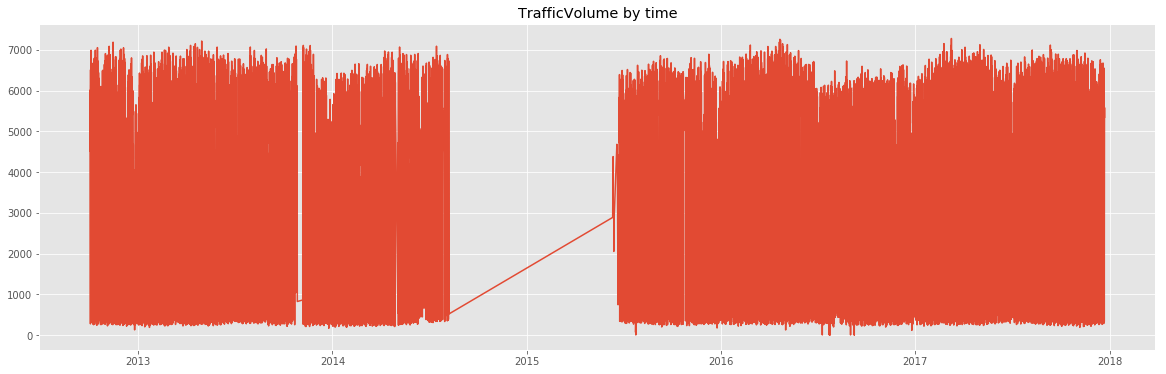

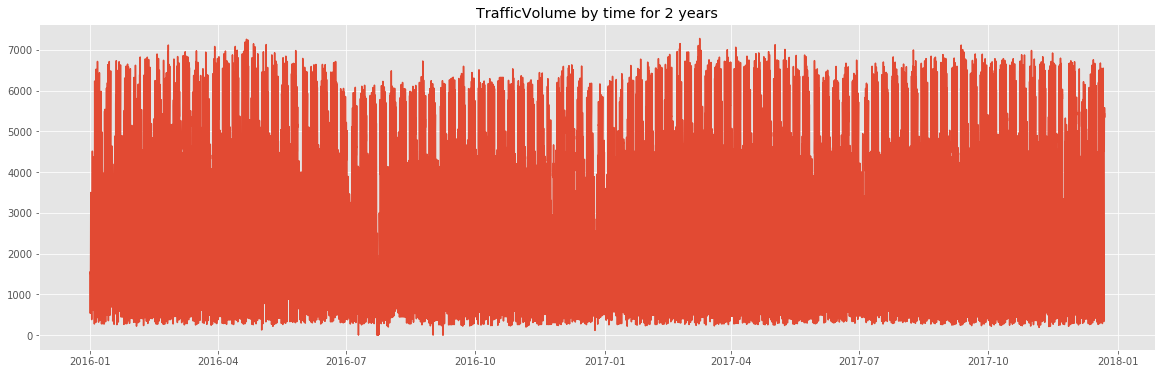

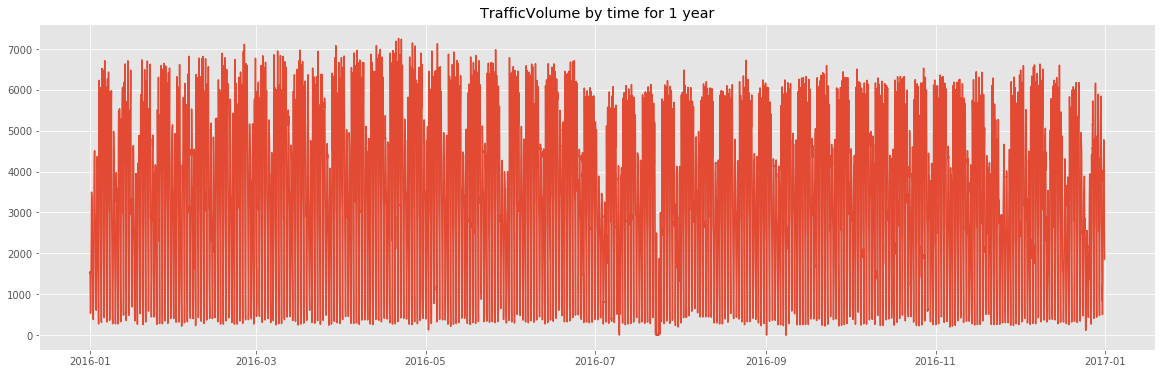

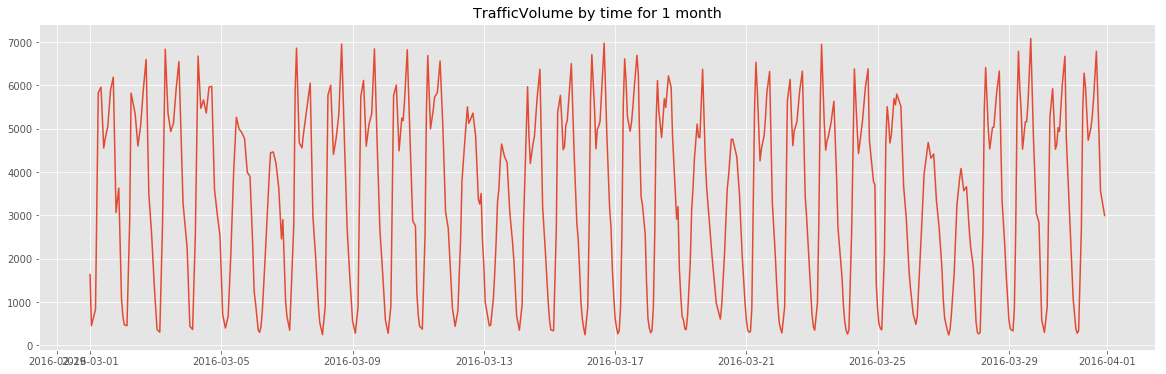

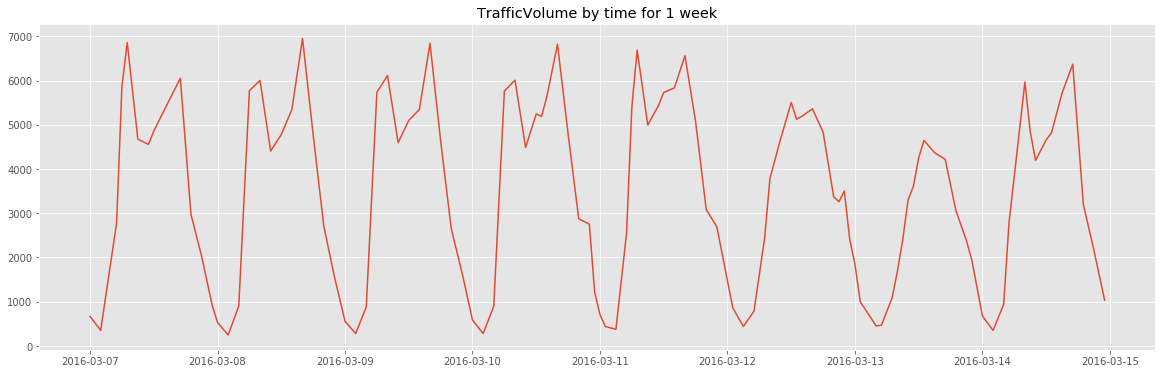

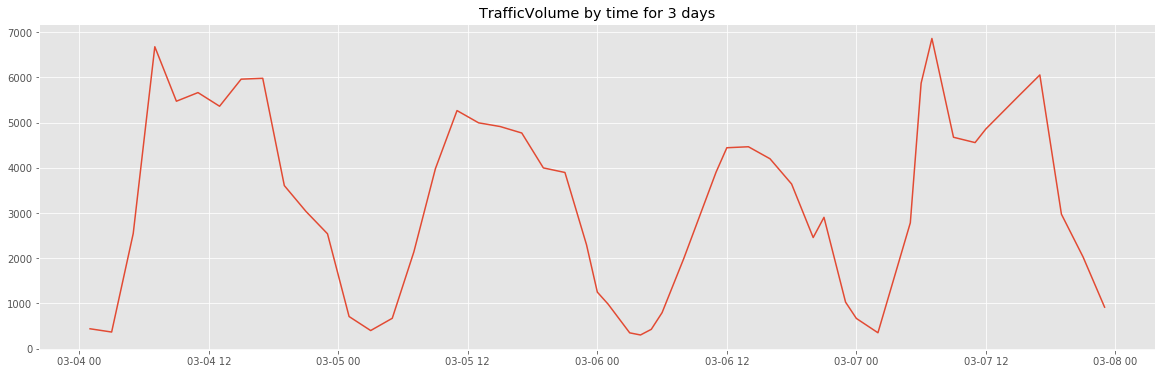

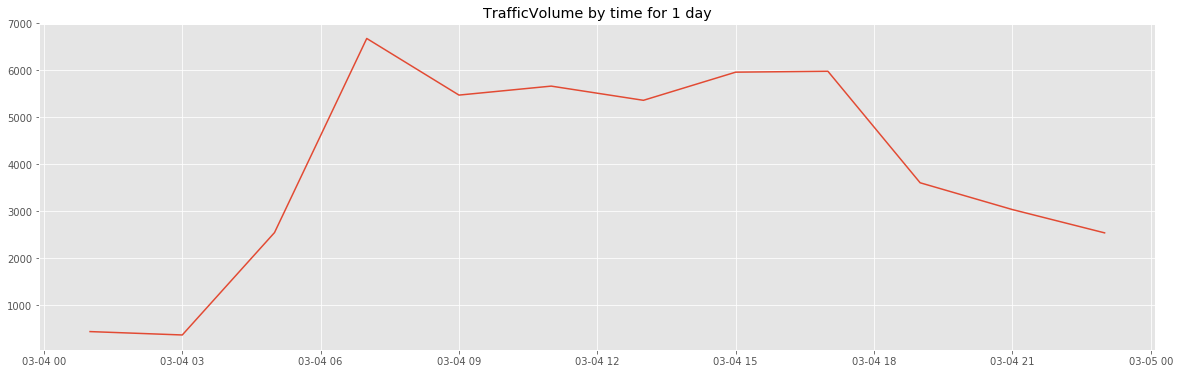

In [4]:

# plot the time series data
fig = plt.figure(figsize=(20,6))
plt.plot(train.Temp)

fig = plt.figure(figsize=(20,6))
plt.plot(train['2016'].Temp)

#All
fig = plt.figure(figsize=(20,6))
plt.plot(train.TrafficVolume)
plt.title('TrafficVolume by time')

fig = plt.figure(figsize=(20,6))
plt.plot(train['2016':].TrafficVolume)
plt.title('TrafficVolume by time for 2 years')

fig = plt.figure(figsize=(20,6))
plt.plot(train['2016'].TrafficVolume)
plt.title('TrafficVolume by time for 1 year')

fig = plt.figure(figsize=(20,6))
plt.plot(train['2016-03'].TrafficVolume)
plt.title('TrafficVolume by time for 1 month')

fig = plt.figure(figsize=(20,6))
plt.plot(train['2016-03-07':'2016-03-14'].TrafficVolume)
plt.title('TrafficVolume by time for 1 week')

pd.Timestamp('2016-03-12').day_name() #Saturday and Sunday lowest traffic

#3 days
fig = plt.figure(figsize=(20,6))
plt.plot(train['2016-03-04':'2016-03-07'].TrafficVolume)
plt.title('TrafficVolume by time for 3 days')
#1 day
fig = plt.figure(figsize=(20,6))
plt.plot(train['2016-03-04'].TrafficVolume)
plt.title('TrafficVolume by time for 1 day')


##Daily trend : peak 7-17
#Weekly trend : saturday and Sunday lowest traffic

train[str(train.TrafficVolume.idxmax())[:10]]

# Step 1 

## 1-11 Regression on Time only


### Feature engineering

In [5]:
train1=train[['TrafficVolume']]
train1['index_no']= [x for x in range(0,len(train1))]
train1['hour']=train1.index.hour
train1['day_name']=train1.index.day_name()
#dayofweek : s0 = monday and 6 = sunday
train1['dayofweek']=train1.index.dayofweek
train1['dayofmonth']=train1.index.day
train1['dayofyear']=train1.index.dayofyear

train1['weekofyear']=train1.index.weekofyear
train1['monthofyear']=train1.index.month

train1['year']=train1.index.year-2012

/home/zhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/zhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/zhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Model training

In [6]:
def modelFitting(y, feature_set, data):
    # Fit model on feature_set and calculate RSS
    formula = y + '~' + '+'.join(feature_set)

    # fit the regression model
    model = smf.ols(formula=formula, data=data).fit()
    return model;

feature_set=['C(hour)','C(dayofweek)','C(monthofyear)','year']

model = modelFitting('TrafficVolume', feature_set, train1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TrafficVolume   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     4911.
Date:                Sat, 16 Nov 2019   Prob (F-statistic):               0.00
Time:                        14:39:05   Log-Likelihood:            -3.2467e+05
No. Observations:               40000   AIC:                         6.494e+05
Df Residuals:                   39958   BIC:                         6.498e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              635.4819     27.117     23.435      0.000     582.331     688.632
C(hour)[T.1]          -306.7032     27.784    -11.039      0.000    -361.161    -252.245
C(hour)[T.2]          -447.1942     27.833    -16.067      0.000    -501.748    -392.640
C(hour)[T.3]          -471.4459     27.896    -16.900      0.000    -526.122    -416.770
C(hour)[T.4]          -133.8727     27.648     -4.842      0.000    -188.064     -79.681
C(hour)[T.5]          1250.6530     27.819     44.957      0.000    1196.127    1305.179
C(hour)[T.6]          3327.9238     27.697    120.157      0.000    3273.638    3382.210
C(hour)[T.7]          3917.9658     27.741    141.232      0.000    3863.592    3972.339
C(hour)[T.8]          3778.9058     27.689    136.478      0.000    3724.635    3833.176
C(hour)[T.9]          3560.6685     27.976    127.275      0.000    3505.835    3615.502
C(hour)[T.10]         3359.2987     27.704    121.255      0.000    3304.997    3413.600
C(hour)[T.11]         3646.0482     28.197    129.308      0.000    3590.782    3701.314
C(hour)[T.12]         3892.3142     28.120    138.420      0.000    3837.199    3947.429
C(hour)[T.13]         3904.7812     28.353    137.723      0.000    3849.210    3960.353
C(hour)[T.14]         4114.8622     28.074    146.572      0.000    4059.837    4169.888
C(hour)[T.15]         4418.0435     28.220    156.560      0.000    4362.733    4473.354
C(hour)[T.16]         4839.3920     28.004    172.810      0.000    4784.503    4894.281
C(hour)[T.17]         4508.7693     28.220    159.770      0.000    4453.457    4564.082
C(hour)[T.18]         3433.7703     28.030    122.504      0.000    3378.831    3488.710
C(hour)[T.19]         2439.9679     28.121     86.767      0.000    2384.850    2495.085
C(hour)[T.20]         1998.4927     28.029     71.301      0.000    1943.555    2053.430
C(hour)[T.21]         1832.3378     28.007     65.424      0.000    1777.443    1887.232
C(hour)[T.22]         1368.7204     27.959     48.954      0.000    1313.920    1423.521
C(hour)[T.23]          628.2224     27.772     22.621      0.000     573.788     682.656
C(dayofweek)[T.1]      205.2955     15.142     13.558      0.000     175.617     234.974
C(dayofweek)[T.2]      256.7943     15.015     17.102      0.000     227.364     286.225
C(dayofweek)[T.3]      310.5708     15.105     20.561      0.000     280.965     340.176
C(dayofweek)[T.4]      330.2617     15.096     21.878      0.000     300.674     359.850
C(dayofweek)[T.5]     -532.9516     15.137    -35.209      0.000    -562.620    -503.283
C(dayofweek)[T.6]     -952.5392     15.080    -63.165      0.000    -982.097    -922.982
C(monthofyear)[T.2]    190.0225     21.275      8.932      0.000     148.324     231.721
C(monthofyear)[T.3]    323.0690     20.875     15.476    

prediction of 500 new datetime

In [7]:
'''function needed for calculating interval of prediction
    fit = modal 
    exog = new dataframe'''
    
def transform_exog_to_model(fit, exog):
    transform=True
    self=fit

    # The following is lifted straight from statsmodels.base.model.Results.predict()
    if transform and hasattr(self.model, 'formula') and exog is not None:
        from patsy import dmatrix
        exog = dmatrix(self.model.data.orig_exog.design_info.builder,
                       exog)

    if exog is not None:
        exog = np.asarray(exog)
        if exog.ndim == 1 and (self.model.exog.ndim == 1 or
                               self.model.exog.shape[1] == 1):
            exog = exog[:, None]
        exog = np.atleast_2d(exog)  # needed in count model shape[1]

    # end lifted code
    return exog


/home/zhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)
  if sys.path[0] == '':


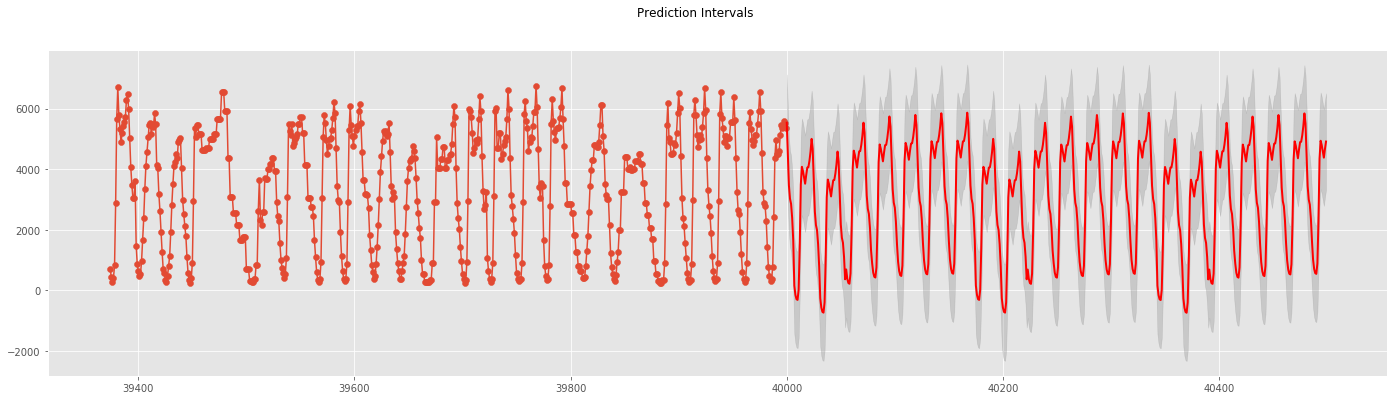

In [8]:
lasttime=pd.Timestamp('2017-12-22 16:00:00')

x_pred_index_no = range(40000,40500)
x_pred_time = [lasttime+i*pd.Timedelta('1:00:00') for i in range (1, len(x_pred_index_no)+1)]

newdf = pd.DataFrame(index=x_pred_time,columns=['index_no'], data= x_pred_index_no)

newdf['year']=newdf.index.year-2012
newdf['monthofyear']=newdf.index.month
newdf['dayofmonth']=newdf.index.day
newdf['dayofweek']=newdf.index.dayofweek
newdf['hour']=newdf.index.hour

y_pred = model.predict(newdf)
transformed_exog = transform_exog_to_model(model, newdf)
from statsmodels.sandbox.regression.predstd import wls_prediction_std
prstd, iv_l, iv_u = wls_prediction_std(model, transformed_exog, weights=[1])

train1_partial=train1['2017-12':]
fig, ax = plt.subplots(figsize=(24, 6))
ax.plot(train1_partial['index_no'], train1_partial['TrafficVolume'])
ax.scatter(train1_partial['index_no'], train1_partial['TrafficVolume'])
fig.suptitle('Prediction Intervals')
ax.grid(True)
ax.plot(list(x_pred_index_no), y_pred, '-', color='red', linewidth=2)
# interval for observations
ax.fill_between(x_pred_index_no, iv_l, iv_u, color='#888888', alpha=0.3)
ax.axis('tight')
plt.show()

In [9]:
##currrent model 

model.rsquared_adj #0.8342458234468448
model.aic #649414.3643822919

##full model
possible_feature=['index_no','hour','C(hour)','dayofweek','C(dayofweek)', 'dayofmonth','C(dayofmonth)','dayofyear','C(dayofyear)','C(weekofyear)','weekofyear','C(monthofyear)','monthofyear','year']
modelfull = modelFitting('TrafficVolume', possible_feature, train1)
modelfull.rsquared_adj  #0.8455436886541244
modelfull.aic #647034.5910585566

##foward  selection
#modelfwd=forward('TrafficVolume', possible_feature, train1, criterion="AIC", fullmodel = None) ##FWD in the following order
possible_feature=['C(hour)', 'C(dayofweek)', 'C(dayofyear)', 'C(weekofyear)', 'C(dayofmonth)', 'C(monthofyear)', 'index_no', 'year', 'weekofyear']
modelfwd=modelFitting('TrafficVolume', possible_feature, train1)

modelfwd.rsquared_adj #0.8455436886541244
modelfwd.aic #647034.5910585565

647034.5910585565

## 1-12 Diagnostic

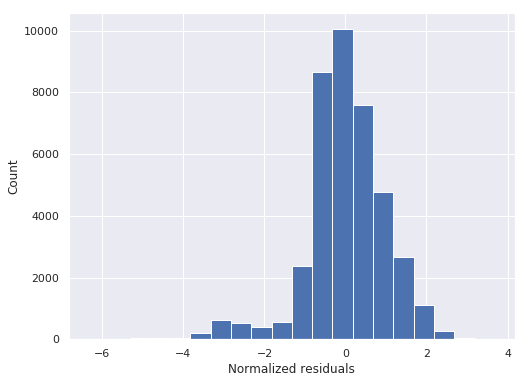

<Figure size 720x720 with 0 Axes>

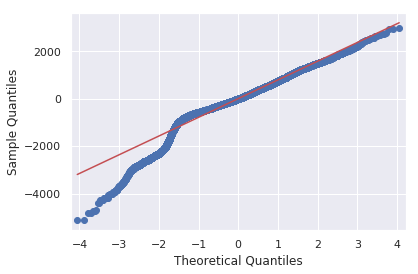

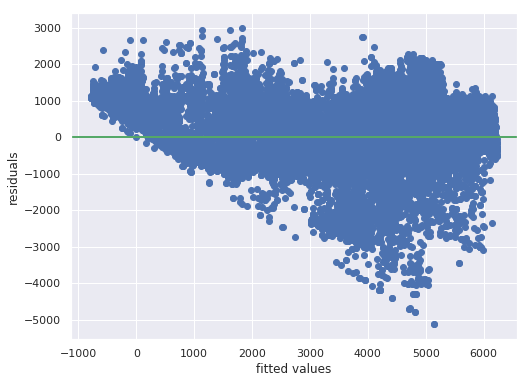

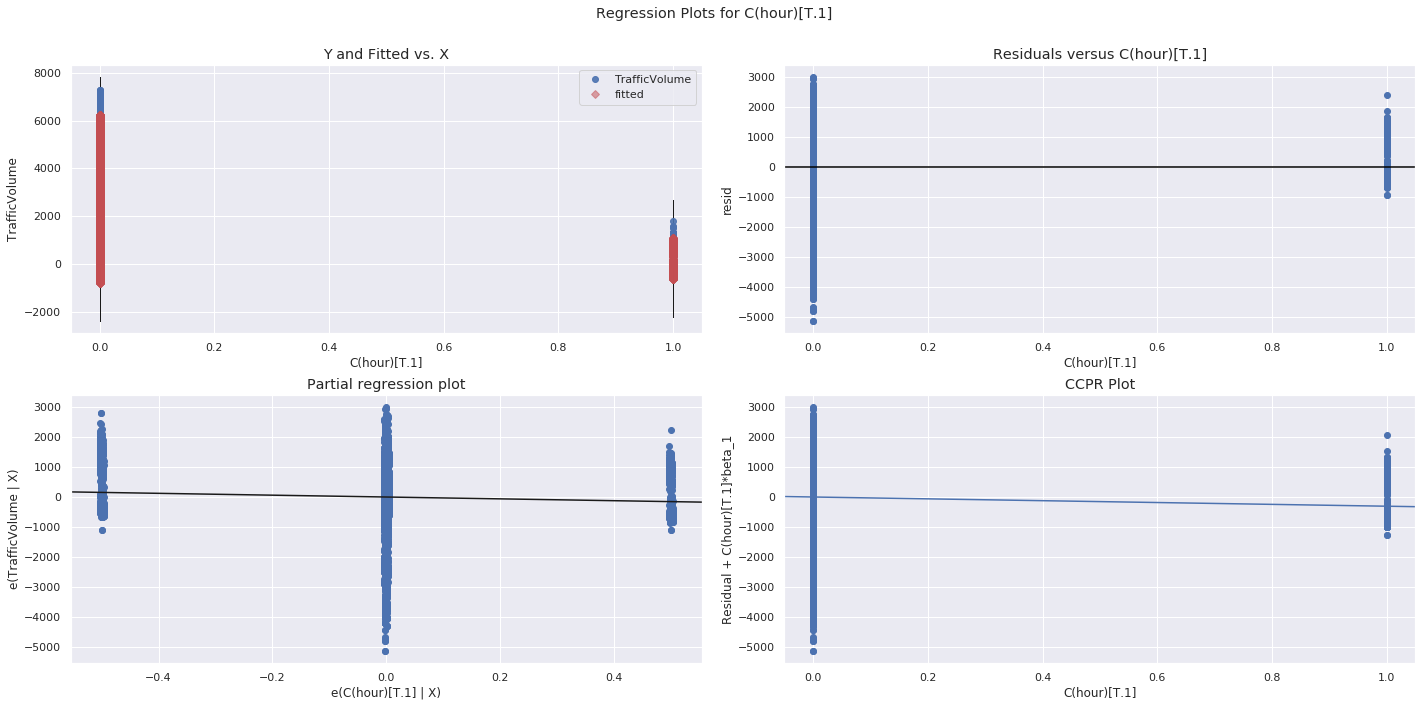

In [10]:
import scipy.stats as stats      #for normal distrib

def diagnosisplot(lm,Features):
    '''plotting Histogram of normalized residuals
       quantile-quantile plot of the residuals
       residuals against fitted value
       partial plots'''
    #1-1Histogram of normalized residuals
    res = lm.resid
    f1 = plt.figure(figsize=(8,6))
    f1 = plt.hist(lm.resid_pearson,bins=20)
    f1 = plt.ylabel('Count')
    f1 = plt.xlabel('Normalized residuals') 

    #1-2 check the normality of the residuals
    #quantile-quantile plot of the residuals
    fig2 = plt.figure(figsize=(10,10))
    fig = sm.qqplot(lm.resid, stats.distributions.norm, line='r') 
    
    #1-3 residuals against fitted value
    fig=plt.figure(figsize=(8,6))
    ax=fig.add_subplot(111)
    ax.scatter(lm.fittedvalues,lm.resid)
    ax.axhline(y=0, linewidth=2, color = 'g')
    ax.set(xlabel='fitted values',ylabel='residuals')
    
    #2 partial plots
    for i in range(0,len(Features)):
        fig1 = plt.figure(figsize=(20,10))
        fig1 = sm.graphics.plot_regress_exog(lm, Features[i],fig=fig1)        

#plots for simple modal 
sns.set(font_scale=1)    
diagnosisplot(model,model.params.index.to_list()[1:
    2]) ##delete the "2" if want to see all variables 

#plots for simple modal with sqrt 

# Step 2 

## 2-1 Moving average 
under assumptions that observations follow a constant trend modal 

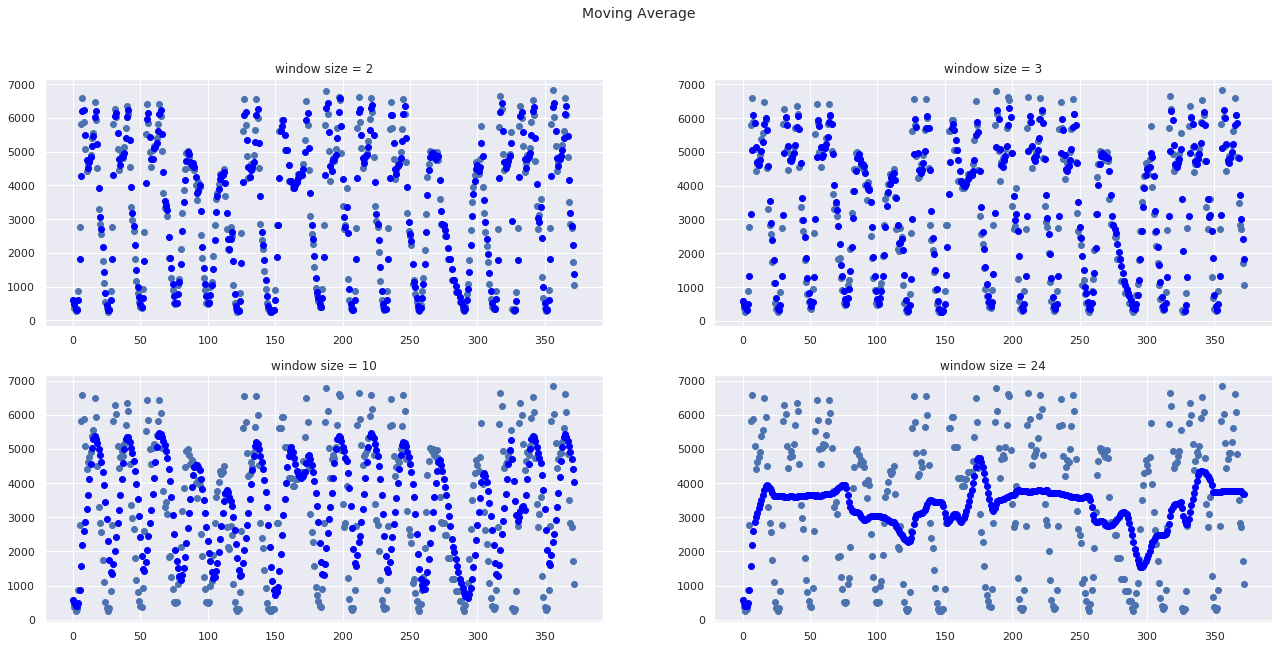

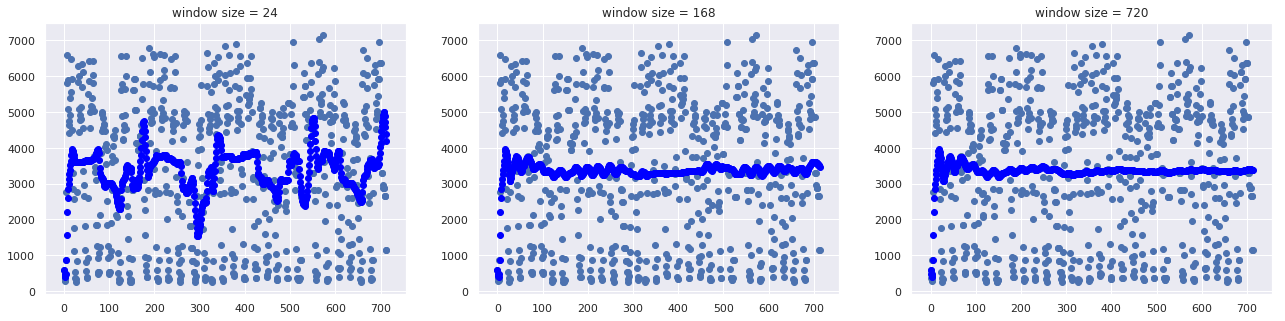

In [11]:
df=train['2017-02-01':'2017-02-15']
y='TrafficVolume'

fig, ax = plt.subplots(2,2,figsize=(22,10))
fig.suptitle("Moving Average", fontsize=14)

win = 2;
ma = df[y].rolling(window=win, min_periods=0, center=False)
ax[0][0].scatter(x=range(0,df.shape[0]), y=df[y])
ax[0][0].scatter(x=range(0,df.shape[0]), y=ma.mean(), color='blue')
ax[0][0].title.set_text('window size = {}'.format(win))
win = 3; 
ma = df[y].rolling(window=win, min_periods=0, center=False)
ax[0][1].scatter(x=range(0,df.shape[0]), y=df[y])
ax[0][1].scatter(x=range(0,df.shape[0]), y=ma.mean(), color='blue')
ax[0][1].title.set_text('window size = {}'.format(win))
win = 10;
ma = df[y].rolling(window=win, min_periods=0, center=False)
ax[1][0].scatter(x=range(0,df.shape[0]), y=df[y])
ax[1][0].scatter(x=range(0,df.shape[0]), y=ma.mean(), color='blue')
ax[1][0].title.set_text('window size = {}'.format(win))
win = 24;
ma = df[y].rolling(window=win, min_periods=0, center=False)
ax[1][1].scatter(x=range(0,df.shape[0]), y=df[y])
ax[1][1].scatter(x=range(0,df.shape[0]), y=ma.mean(), color='blue')
ax[1][1].title.set_text('window size = {}'.format(win))



df=train['2017-02']
y='TrafficVolume'

fig, ax = plt.subplots(1,3,figsize=(22,5))
win = 24;
ma = df[y].rolling(window=win, min_periods=0, center=False)
ax[0].scatter(x=range(0,df.shape[0]), y=df[y])
ax[0].scatter(x=range(0,df.shape[0]), y=ma.mean(), color='blue')
ax[0].title.set_text('window size = {}'.format(win))

win = 168; # 24*7
ma = df[y].rolling(window=win, min_periods=0, center=False)
ax[1].scatter(x=range(0,df.shape[0]), y=df[y])
ax[1].scatter(x=range(0,df.shape[0]), y=ma.mean(), color='blue')
ax[1].title.set_text('window size = {}'.format(win))

win = 720; # 24*30
ma = df[y].rolling(window=win, min_periods=0, center=False)
ax[2].scatter(x=range(0,df.shape[0]), y=df[y])
ax[2].scatter(x=range(0,df.shape[0]), y=ma.mean(), color='blue')
ax[2].title.set_text('window size = {}'.format(win))

## 2-2 Exponentially weighted moving average 
under assumptions that observations follow a constant trend modal

### 2-21 EWMA

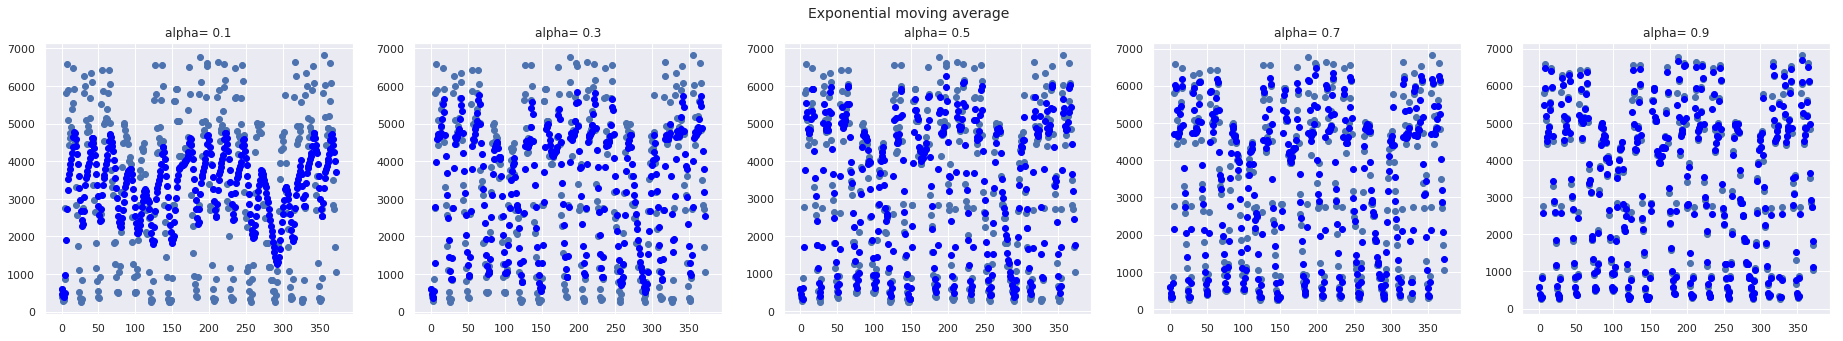

In [12]:
df=train['2017-02-01':'2017-02-15']
y='TrafficVolume'

fig, ax = plt.subplots(1,5,figsize=(32,5))
fig.suptitle("Exponential moving average", fontsize=14)
al = 0.1;

ewma = df[y].ewm(alpha=al, min_periods=0)
ax[0].scatter(x=range(0,df.shape[0]), y=df[y])
ax[0].scatter(x=range(0,df.shape[0]), y=ewma.mean(), color='blue')
ax[0].title.set_text('alpha= {}'.format(al))

al = 0.3;
ewma = df[y].ewm(alpha=al, min_periods=0)
ax[1].scatter(x=range(0,df.shape[0]), y=df[y])
ax[1].scatter(x=range(0,df.shape[0]), y=ewma.mean(), color='blue')
ax[1].title.set_text('alpha= {}'.format(al))

al = 0.5;
ewma = df[y].ewm(alpha=al, min_periods=0)
ax[2].scatter(x=range(0,df.shape[0]), y=df[y])
ax[2].scatter(x=range(0,df.shape[0]), y=ewma.mean(), color='blue')
ax[2].title.set_text('alpha= {}'.format(al))

al = 0.7;
ewma = df[y].ewm(alpha=al, min_periods=0)
ax[3].scatter(x=range(0,df.shape[0]), y=df[y])
ax[3].scatter(x=range(0,df.shape[0]), y=ewma.mean(), color='blue')
ax[3].title.set_text('alpha= {}'.format(al))

al = 0.9;
ewma = df[y].ewm(alpha=al, min_periods=0)
ax[4].scatter(x=range(0,df.shape[0]), y=df[y])
ax[4].scatter(x=range(0,df.shape[0]), y=ewma.mean(), color='blue')
ax[4].title.set_text('alpha= {}'.format(al))

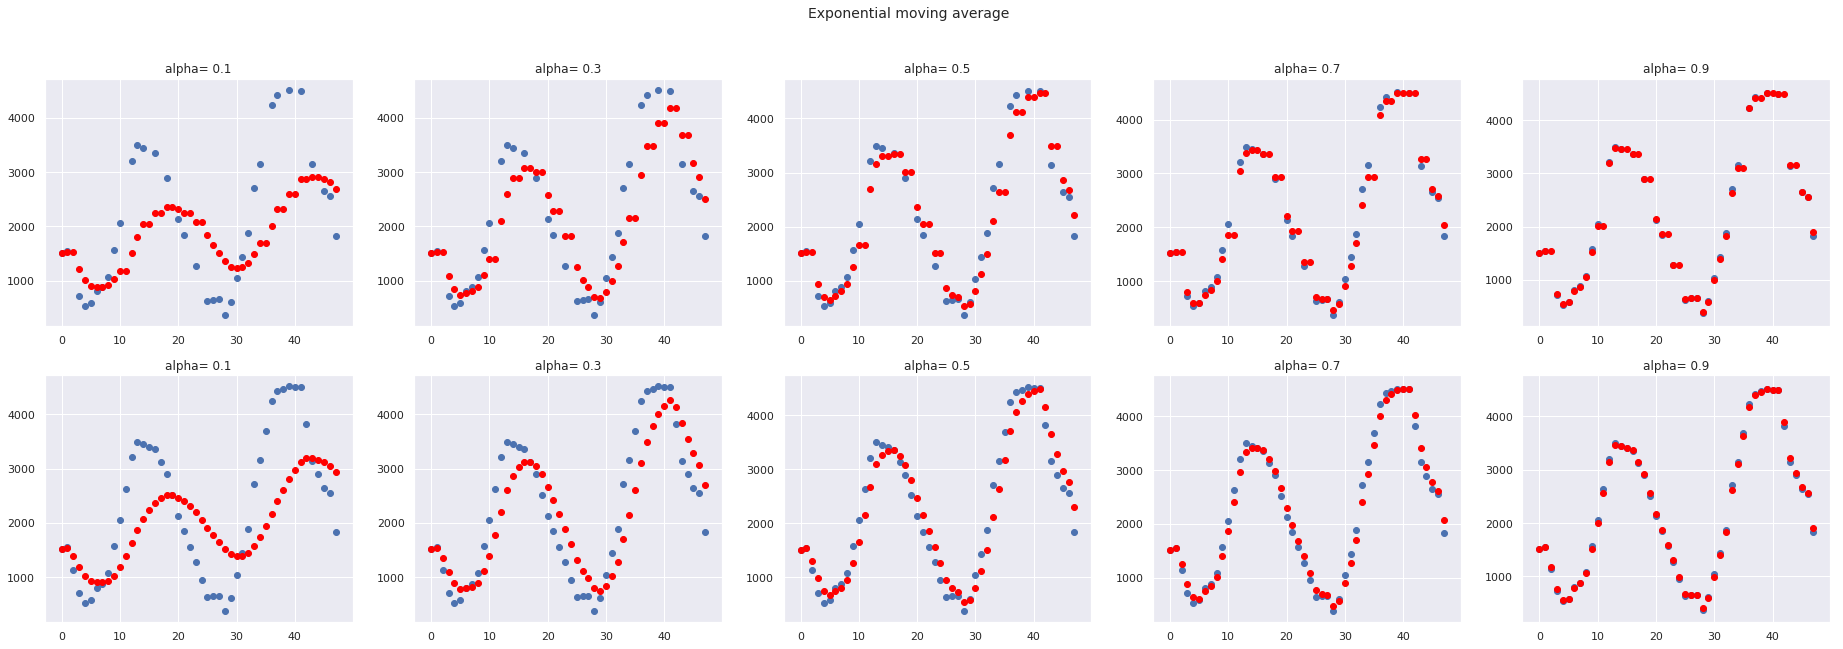

In [13]:

df=train.resample('H').first()['2016-1-01':'2016-1-02']
y='TrafficVolume'

fig, ax = plt.subplots(2,5,figsize=(32,10))
fig.suptitle("Exponential moving average", fontsize=14)
al = 0.1;

ewma = df[y].ewm(alpha=al, min_periods=0)
ax[0,0].scatter(x=range(0,df.shape[0]), y=df[y])
ax[0,0].scatter(x=range(0,df.shape[0]), y=ewma.mean(), color='red')
ax[0,0].title.set_text('alpha= {}'.format(al))

al = 0.3;
ewma = df[y].ewm(alpha=al, min_periods=0)
ax[0,1].scatter(x=range(0,df.shape[0]), y=df[y])
ax[0,1].scatter(x=range(0,df.shape[0]), y=ewma.mean(), color='red')
ax[0,1].title.set_text('alpha= {}'.format(al))

al = 0.5;
ewma = df[y].ewm(alpha=al, min_periods=0)
ax[0,2].scatter(x=range(0,df.shape[0]), y=df[y])
ax[0,2].scatter(x=range(0,df.shape[0]), y=ewma.mean(), color='red')
ax[0,2].title.set_text('alpha= {}'.format(al))

al = 0.7;
ewma = df[y].ewm(alpha=al, min_periods=0)
ax[0,3].scatter(x=range(0,df.shape[0]), y=df[y])
ax[0,3].scatter(x=range(0,df.shape[0]), y=ewma.mean(), color='red')
ax[0,3].title.set_text('alpha= {}'.format(al))

al = 0.9;
ewma = df[y].ewm(alpha=al, min_periods=0)
ax[0,4].scatter(x=range(0,df.shape[0]), y=df[y])
ax[0,4].scatter(x=range(0,df.shape[0]), y=ewma.mean(), color='red')
ax[0,4].title.set_text('alpha= {}'.format(al))

#####################CLEANED#################
df=train.resample('H').first().interpolate()['2016-1-01':'2016-1-02']
y='TrafficVolume'

al = 0.1;
ewma = df[y].ewm(alpha=al, min_periods=0)
ax[1,0].scatter(x=range(0,df.shape[0]), y=df[y])
ax[1,0].scatter(x=range(0,df.shape[0]), y=ewma.mean(), color='red')
ax[1,0].title.set_text('alpha= {}'.format(al))

al = 0.3;
ewma = df[y].ewm(alpha=al, min_periods=0)
ax[1,1].scatter(x=range(0,df.shape[0]), y=df[y])
ax[1,1].scatter(x=range(0,df.shape[0]), y=ewma.mean(), color='red')
ax[1,1].title.set_text('alpha= {}'.format(al))

al = 0.5;
ewma = df[y].ewm(alpha=al, min_periods=0)
ax[1,2].scatter(x=range(0,df.shape[0]), y=df[y])
ax[1,2].scatter(x=range(0,df.shape[0]), y=ewma.mean(), color='red')
ax[1,2].title.set_text('alpha= {}'.format(al))

al = 0.7;
ewma = df[y].ewm(alpha=al, min_periods=0)
ax[1,3].scatter(x=range(0,df.shape[0]), y=df[y])
ax[1,3].scatter(x=range(0,df.shape[0]), y=ewma.mean(), color='red')
ax[1,3].title.set_text('alpha= {}'.format(al))

al = 0.9;
ewma = df[y].ewm(alpha=al, min_periods=0)
ax[1,4].scatter(x=range(0,df.shape[0]), y=df[y])
ax[1,4].scatter(x=range(0,df.shape[0]), y=ewma.mean(), color='red')
ax[1,4].title.set_text('alpha= {}'.format(al))


### 2-22 selecting the smoothing parameters to minimize error 
SSE = sum[Y(i)-L(i-1)]² 
L(n) = alpha* Y(n) + (1-alpha)*L(n-1) = sum over i=1 to n of [(alpha*(1-alpha)^(n-i))*Y(i)]
L(n-1) = previous mean values 
if alpha = 1  then L(n)=Y(n) ie the prediction is equal to the data 

Text(0.5, 1.0, 'prediction error given alpha with optimal alpha = 1.0')

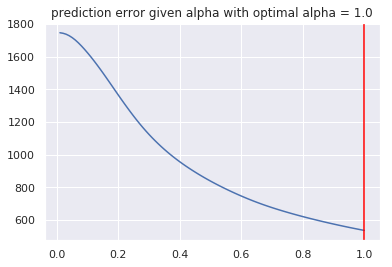

In [14]:
df=train
alpha = np.linspace(0.01,1,num=100)
err = [];
sses = pd.DataFrame()
for al in alpha:
    ewma = df[y].ewm(alpha=al, min_periods=0)  
    pred = ewma.mean(); # compute L 
    diff = df[y] - pred.shift(1);  ## we compare Y(i) and L(i-1)
    sse=np.sqrt(diff ** 2)
    sses['sse'+str(al)]=sse
    err.append(sse.mean())
    
plt.plot(alpha, err)
optal = alpha[np.argmin(err)]
plt.axvline(x=optal, color='red')
plt.title('prediction error given alpha with optimal alpha = {}'.format(optal))

In [15]:
df=train
df[y]

Time
2012-10-02 09:00:00    5545
2012-10-02 10:00:00    4516
2012-10-02 11:00:00    4767
2012-10-02 12:00:00    5026
2012-10-02 13:00:00    4918
                       ... 
2017-12-22 12:00:00    5447
2017-12-22 13:00:00    5349
2017-12-22 14:00:00    5581
2017-12-22 15:00:00    5510
2017-12-22 16:00:00    5346
Name: TrafficVolume, Length: 40000, dtype: int64

In [16]:
ewma = df[y].ewm(alpha=1, min_periods=0)  
pred = ewma.mean(); # compute L 
print(pred)

Time
2012-10-02 09:00:00    5545.0
2012-10-02 10:00:00    4516.0
2012-10-02 11:00:00    4767.0
2012-10-02 12:00:00    5026.0
2012-10-02 13:00:00    4918.0
                        ...  
2017-12-22 12:00:00    5447.0
2017-12-22 13:00:00    5349.0
2017-12-22 14:00:00    5581.0
2017-12-22 15:00:00    5510.0
2017-12-22 16:00:00    5346.0
Name: TrafficVolume, Length: 40000, dtype: float64


In [17]:
diff = df[y] - pred.shift(1);  ## we compare Y(i) and L(i-1)
diff

Time
2012-10-02 09:00:00       NaN
2012-10-02 10:00:00   -1029.0
2012-10-02 11:00:00     251.0
2012-10-02 12:00:00     259.0
2012-10-02 13:00:00    -108.0
                        ...  
2017-12-22 12:00:00     308.0
2017-12-22 13:00:00     -98.0
2017-12-22 14:00:00     232.0
2017-12-22 15:00:00     -71.0
2017-12-22 16:00:00    -164.0
Name: TrafficVolume, Length: 40000, dtype: float64

In [18]:
sse=np.sqrt(diff ** 2)
sse

Time
2012-10-02 09:00:00       NaN
2012-10-02 10:00:00    1029.0
2012-10-02 11:00:00     251.0
2012-10-02 12:00:00     259.0
2012-10-02 13:00:00     108.0
                        ...  
2017-12-22 12:00:00     308.0
2017-12-22 13:00:00      98.0
2017-12-22 14:00:00     232.0
2017-12-22 15:00:00      71.0
2017-12-22 16:00:00     164.0
Name: TrafficVolume, Length: 40000, dtype: float64

### 2-23 Assumptions verifications

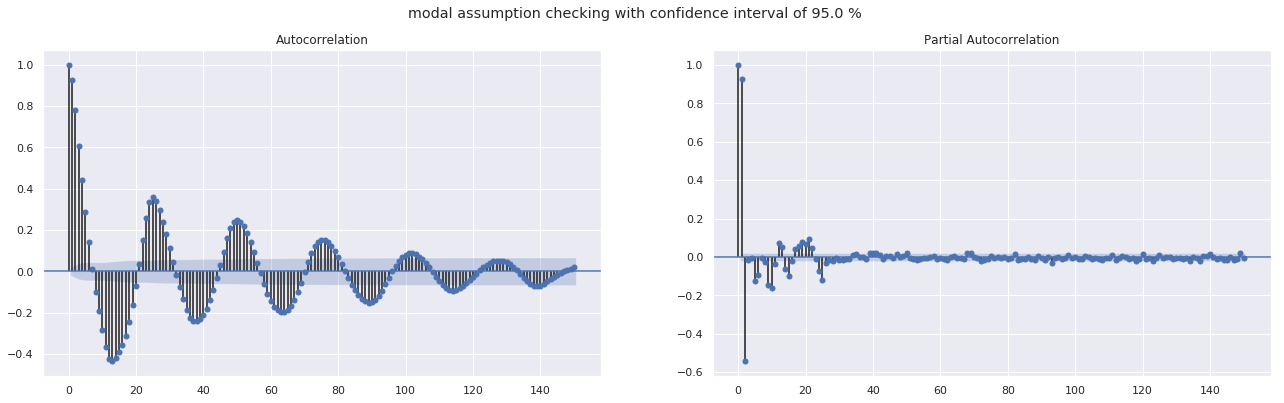

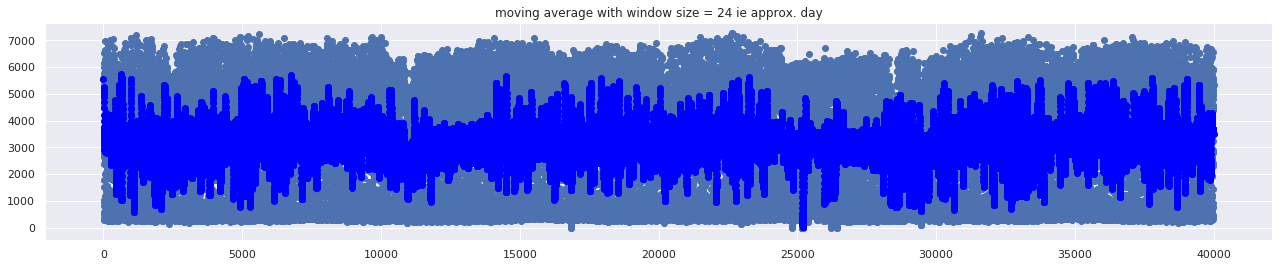

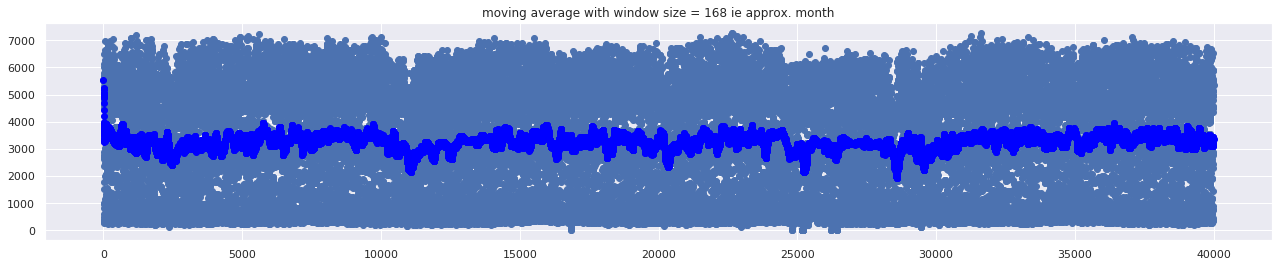

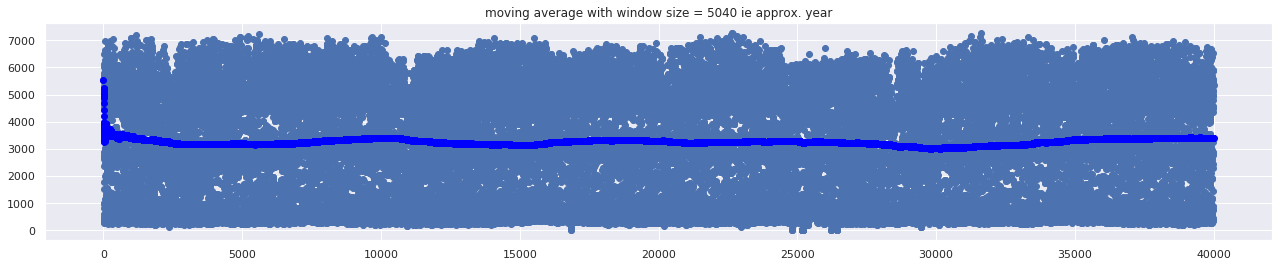

In [19]:
## seasonal testing
alpha=0.05 # 95 % confidence intervals 
lags =150
#24*7=168
#168*30=5040
data =train['TrafficVolume']['2017']
fig, ax = plt.subplots(1,2,figsize=(22,6))
fig.suptitle('modal assumption checking with confidence interval of {} % '.format((1-alpha)*100))
fig = sgt.plot_acf(data, ax=ax[0], lags=lags, alpha=alpha, unbiased=True)
fig = sgt.plot_pacf(data, ax=ax[1], lags=lags, alpha=alpha, method='ols')

## trend testing
df=train
y='TrafficVolume'
wins =[24,24*7,24*7*30]
wins_exp = {24 : 'approx. day',24*7 :'approx. month', 24*7*30 : 'approx. year'}
for win in wins :
    fig, ax = plt.subplots(1,1,figsize=(22,4))
    ma = df[y].rolling(window=win, min_periods=0, center=False)
    ax.scatter(x=range(0,df.shape[0]), y=df[y])
    ax.scatter(x=range(0,df.shape[0]), y=ma.mean(), color='blue')
    ax.title.set_text('moving average with window size = {} ie {}'.format(win,wins_exp[win]))

## 2-3 Trend Corrected Smoothing 

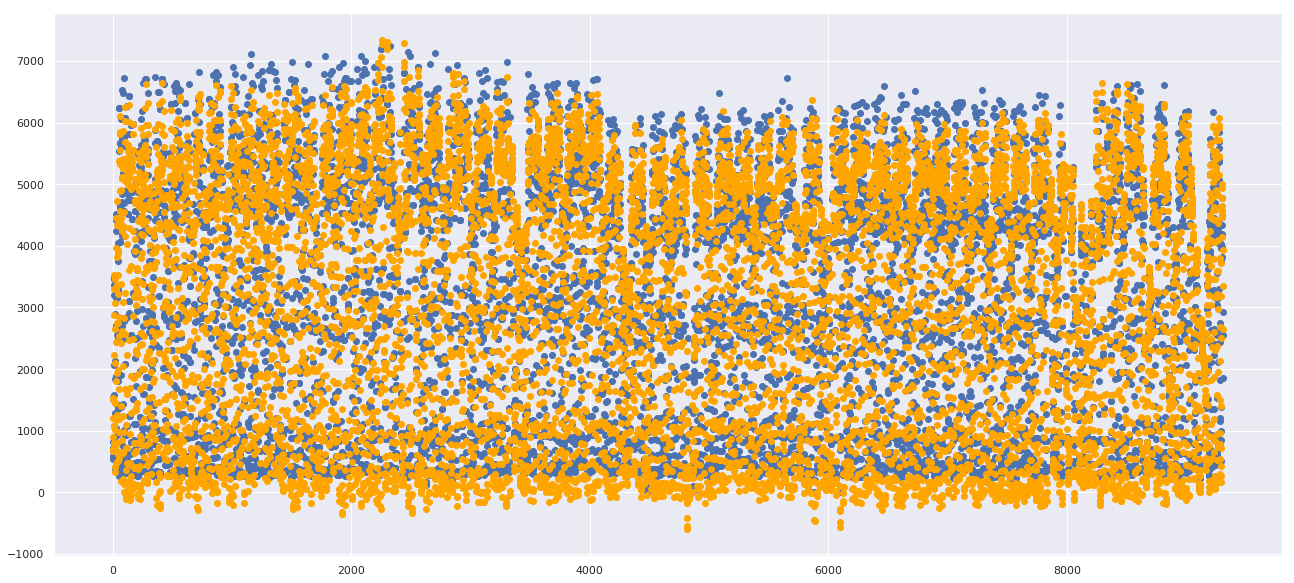

In [20]:
def double_exponential_smoothing(series, alpha, beta, L0, B0):
    result = []
    for n in range(0, len(series)):
        val = series[n]
        if n==0:
            level = alpha*val + (1-alpha)*(L0+B0); ##level(1)
            trend = beta*(level-L0) + (1-beta)*B0; ##trend(1)
            last_level = level;
        else:
            level = alpha*val + (1-alpha)*(last_level+trend) #trend = B(n-1)
            trend = beta*(level-last_level) + (1-beta)*trend
            last_level = level;
            
        result.append(level)
    return result

alpha = 0.4; #
beta = 0.2; #
df=train['2016']
y='TrafficVolume'
series = df[y].values
holt = double_exponential_smoothing(series, alpha, beta,series[0], series[1]-series[0])
fig = plt.figure(figsize=(22,10))
plt.scatter(x=range(0,df.shape[0]), y=df[y])
plt.scatter(x=range(0,df.shape[0]), y=holt, color='orange')

## 2-3 Holt-WInters Smoothing  Y(t)= b0+ SN(t) + e(t)
Supposed form of observation Y : Y(t)= B0 + beta1*t +e(t)

Prediction/level L : L(n) = alpha *Y(n) + (1-alpha)*(L(n-1)+ B(n-1))

Trend term B(n) = beta*(L(n)-L(n-1)) + (1-beta)*beta(n-1) given a series, alpha and beta, return series of smoothed points

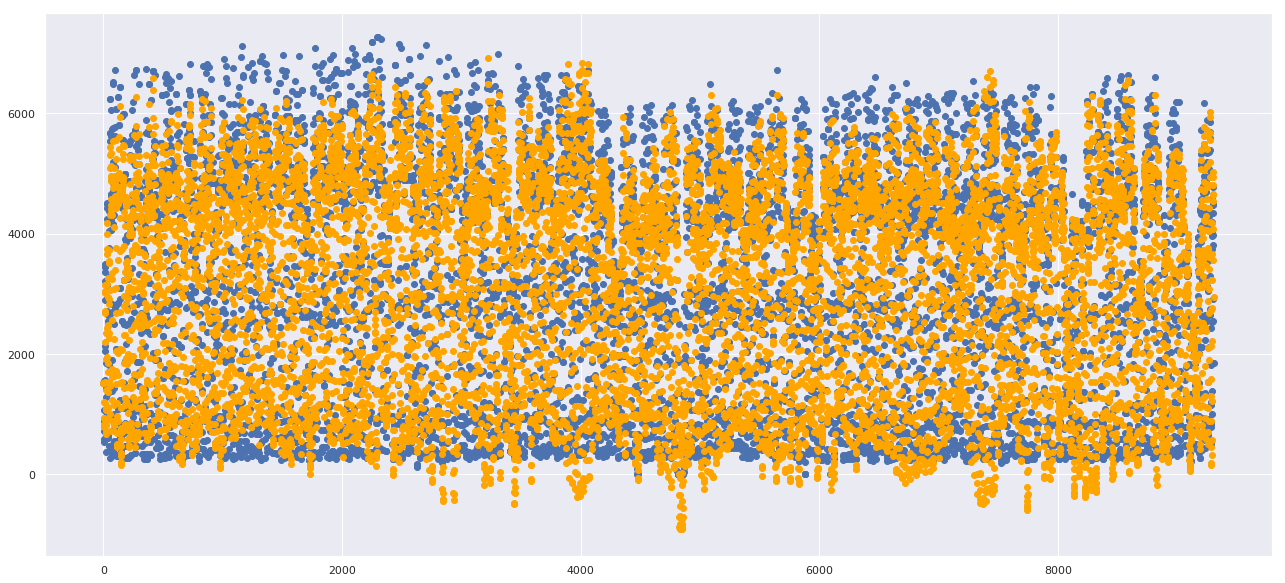

In [21]:
def HoltWinters(series, alpha, beta, L0, B0):
    result = []
    seasons= []
    L=24 #period of hours
    for n in range(0, len(series)):
        val = series[n]
        
        #initiation of 1
        if n==0:
            level = alpha*(val - 0) + (1-alpha)*(L0); ##level(1)
            season = beta*(val-L0) + 0  ; ##season(1)
            seasons.append(season) # we store the season term in seasons
            last_level = level; # we store the current level in last_level
        
        #initiation of 2 to 23 for season terms
        elif (n!=0 and n-23<=0):
            level = alpha*(val - 0) + (1-alpha)*(last_level);
            season = beta*(val-level) + 0 ;
            seasons.append(season)
            last_level = level; 
        
        else:
            ##level(n) need season(n-L) with L=24 
            ##since season(n) has not been appended to seasons, season(n-L) = seasons[-L+1]
            level = alpha*(val - seasons[-L+1]) + (1-alpha)*(last_level);
            season = beta*(val-level) + (1-beta)* + seasons[-L+1];
            seasons.append(season)
            last_level = level; 
            
        result.append(level)
    return result

alpha = 0.4; #
beta = 0.1; #
df=train['2016']
y='TrafficVolume'
series = df[y].values
holt = HoltWinters(series, alpha, beta,series[0], series[1]-series[0])
fig = plt.figure(figsize=(22,10))
plt.scatter(x=range(0,df.shape[0]), y=df[y])
plt.scatter(x=range(0,df.shape[0]), y=holt, color='orange')

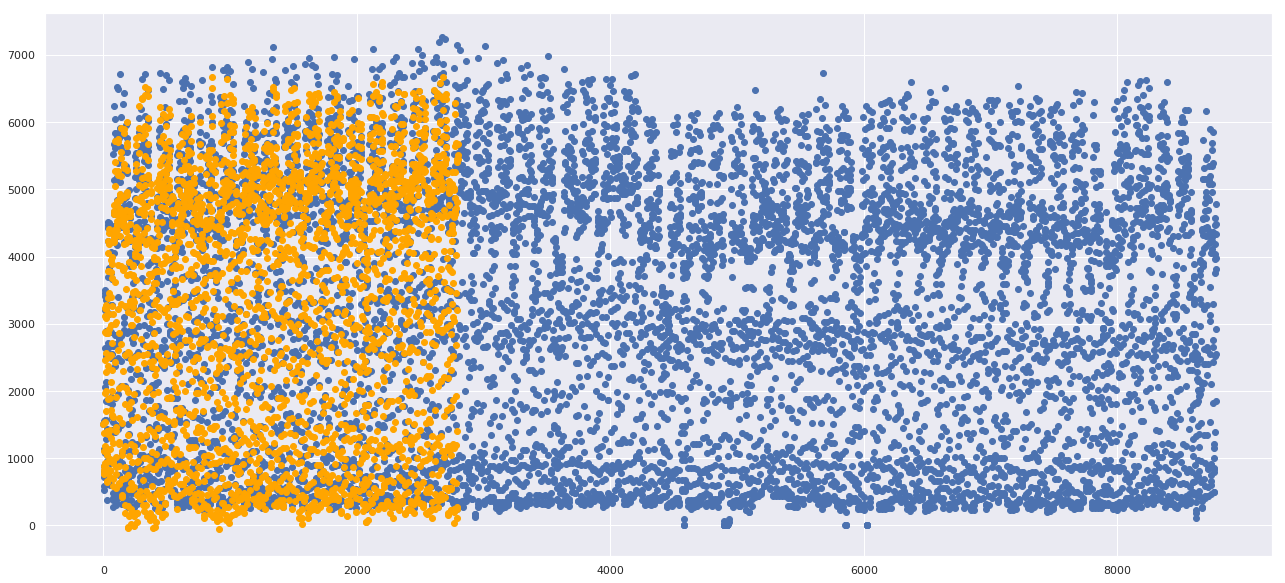

In [22]:
alpha = 0.4; #
beta = 0.1; #
df=train.resample('H').first().interpolate(limit=3)['2016']
y='TrafficVolume'

series = df[y].values
holt = HoltWinters(series, alpha, beta,series[0], series[1]-series[0])
fig = plt.figure(figsize=(22,10))
plt.scatter(x=range(0,df.shape[0]), y=df[y])
plt.scatter(x=range(0,df.shape[0]), y=holt, color='orange')

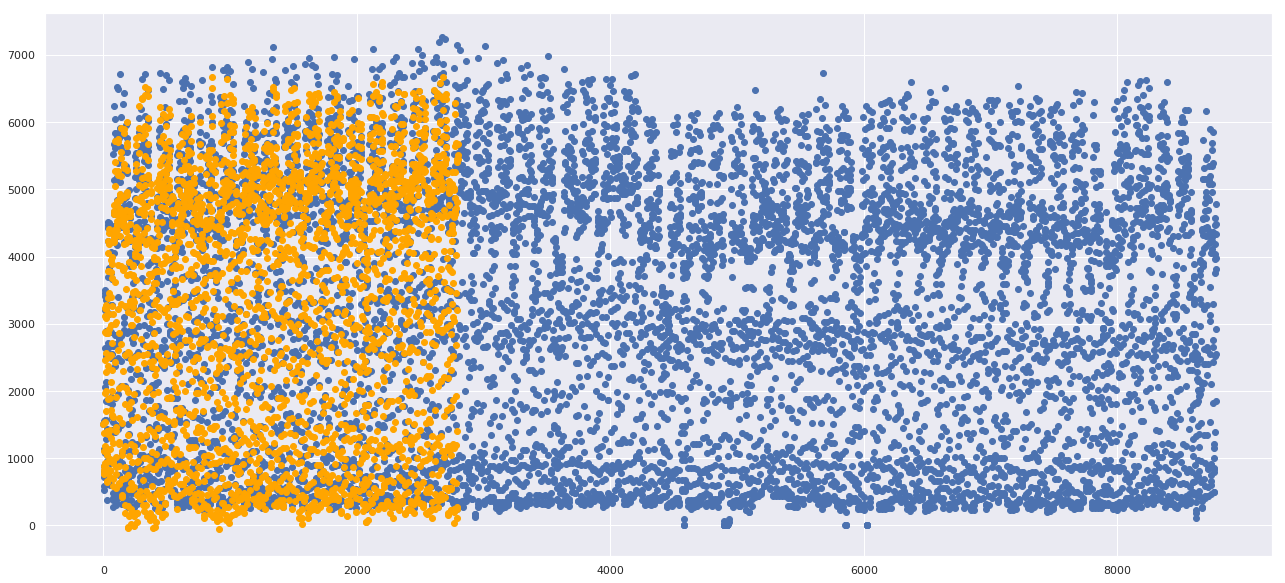

In [23]:
alpha = 0.4; #
beta = 0.1; #
df=train.resample('H').first().interpolate(limit=3)['2016']

y='TrafficVolume'

series = df[y].values
holt = HoltWinters(series, alpha, beta,series[0], series[1]-series[0])
fig = plt.figure(figsize=(22,10))
plt.scatter(x=range(0,df.shape[0]), y=df[y])
plt.scatter(x=range(0,df.shape[0]), y=holt, color='orange')

/home/zhou/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/zhou/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/zhou/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/zhou/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  Va

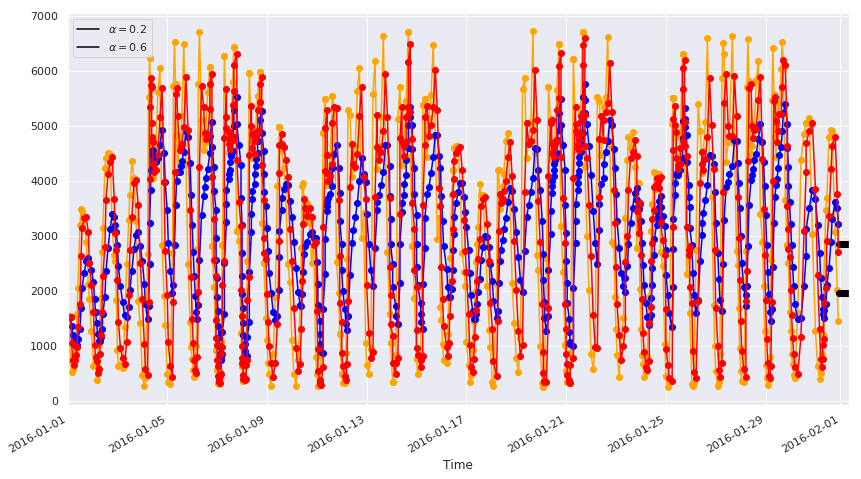

In [24]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
df=train['2016-01']

y='TrafficVolume'
nber =10
fit1 = SimpleExpSmoothing(df[y]).fit(smoothing_level=0.2,optimized=False)
fcast1 = fit1.forecast(nber).rename(r'$\alpha=0.2$')
fcast1.index= pd.date_range(start=df.index[-1]+pd.DateOffset(hours=1),periods=nber,freq='H')

fit2 = SimpleExpSmoothing(df[y]).fit(smoothing_level=0.6,optimized=False)
fcast2 = fit2.forecast(nber).rename(r'$\alpha=0.6$')
fcast2.index= pd.date_range(start=df.index[-1]+pd.DateOffset(hours=1),periods=nber,freq='H')

ax = df[y].plot(marker='o', color='orange', figsize=(14,8))
fcast1.plot(marker='o', ax=ax, color='black', legend=True)
fit1.fittedvalues.plot(marker='o', ax=ax, color='blue')
fcast2.plot(marker='o', ax=ax, color='black', legend=True)
fit2.fittedvalues.plot(marker='o', ax=ax, color='red')


/home/zhou/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/zhou/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/zhou/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/zhou/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/zhou/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219

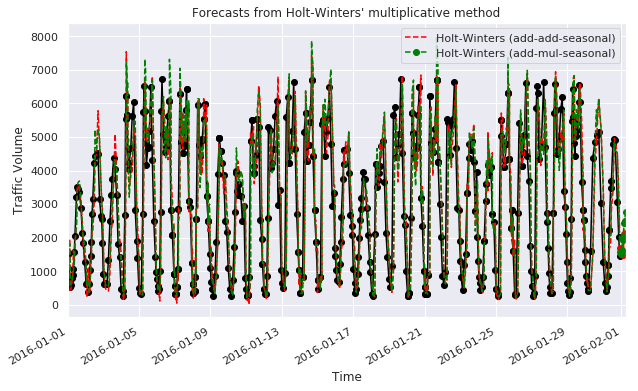

Figure 7.6: Forecasting using Holt-Winters method with both additive and multiplicative seasonality.


Additive  Multiplicative  Additive Dam  Multiplica Dam
$\alpha$  9.473684e-01    9.934039e-01  9.473684e-01    9.473684e-01
$\beta$            NaN    5.636158e-03  9.473684e-01    9.473684e-01
$\phi$             NaN             NaN  3.846417e-01    2.631581e-01
$\gamma$  5.263158e-02    6.596080e-03  5.263158e-02    5.263158e-02
$l_0$     1.701769e+02    1.672552e+02  1.686699e+02    1.672552e+02
$b_0$              NaN    2.059549e+00  1.067860e+00    5.420808e-01
SSE       8.002075e+08    7.651713e+08  7.695100e+08    1.607955e+09

In [25]:
df=train.loc['2016-01':'2016-01-31']
y='TrafficVolume'
nber=8 
fit1 = ExponentialSmoothing(df[y], seasonal_periods=24, seasonal='add').fit(use_boxcox=True)
fit2 = ExponentialSmoothing(df[y], seasonal_periods=24, trend='add', seasonal='mul').fit(use_boxcox=True)
fit3 = ExponentialSmoothing(df[y], seasonal_periods=24, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
fit4 = ExponentialSmoothing(df[y], seasonal_periods=24, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"]   = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

ax = df[y].plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
ax.set_ylabel("Traffic Volume")
ax.set_xlabel("Date hour")
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit2.fittedvalues.plot(ax=ax, style='--', color='green')

fcast2=fit2.forecast(nber).rename('Holt-Winters (add-mul-seasonal)')
fcast2.index= pd.date_range(start=df.index[-1]+pd.DateOffset(hours=1),periods=nber,freq='H')

fcast1=fit1.forecast(nber).rename('Holt-Winters (add-add-seasonal)')
fcast1.index= pd.date_range(start=df.index[-1]+pd.DateOffset(hours=1),periods=nber,freq='H')

fcast1.plot(ax=ax, style='--', marker='o', color='red', legend=True)
fcast2.plot(ax=ax, style='--', marker='o', color='green', legend=True)

plt.show()
print("Figure 7.6: Forecasting using Holt-Winters method with both additive and multiplicative seasonality.")

results

1.0


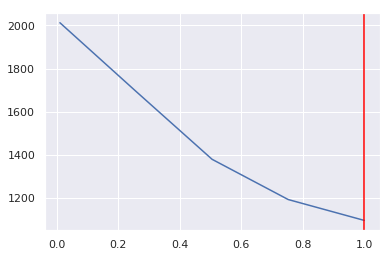

In [26]:
alphas = np.linspace(0.01,1,num=5)
betas = np.linspace(0.01,1,num=5)

series = df[y].values
err = [];
beta= 0
for alpha in alphas:
   # for beta in betas:
    holt = HoltWinters(series, alpha, beta,series[0], series[1]-series[0]);
    pred = pd.Series(holt,index=df.index);
    diff = df[y] - pred.shift(1);
    err.append(np.sqrt((diff ** 2).mean()))
    
plt.plot(alphas, err)
optal = alphas[np.argmin(err)]
plt.axvline(x=optal, color='red')
print(optal)

## 2-4 Testing 


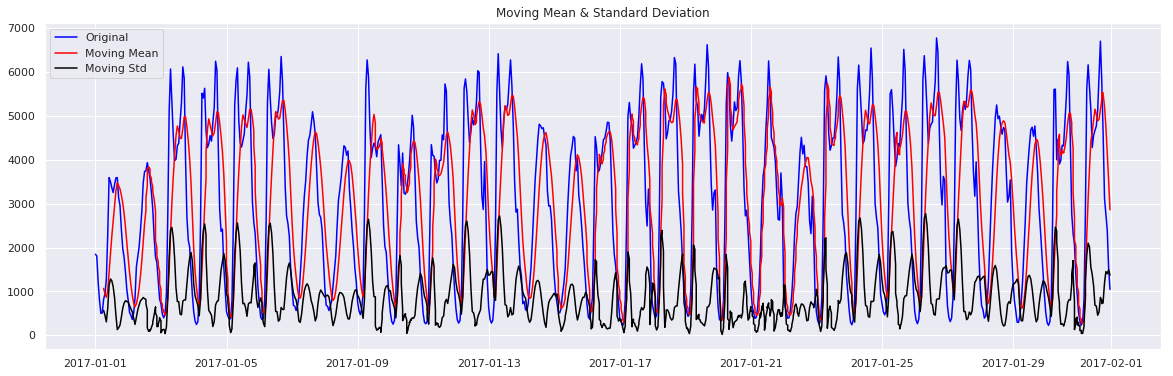

In [27]:
# plot the moving average/std with window size = period
df=train['TrafficVolume']['2017-01']

moving = df.rolling(window=7, min_periods=None, center=False)
#Plot rolling statistics:
fig = plt.figure(figsize=(20,6))
orig = plt.plot(df, color='blue',label='Original')
mean = plt.plot(moving.mean(), color='red', label='Moving Mean')
std = plt.plot(moving.std(), color='black', label = 'Moving Std')
plt.legend(loc='best')
plt.title('Moving Mean & Standard Deviation')
plt.show()
##


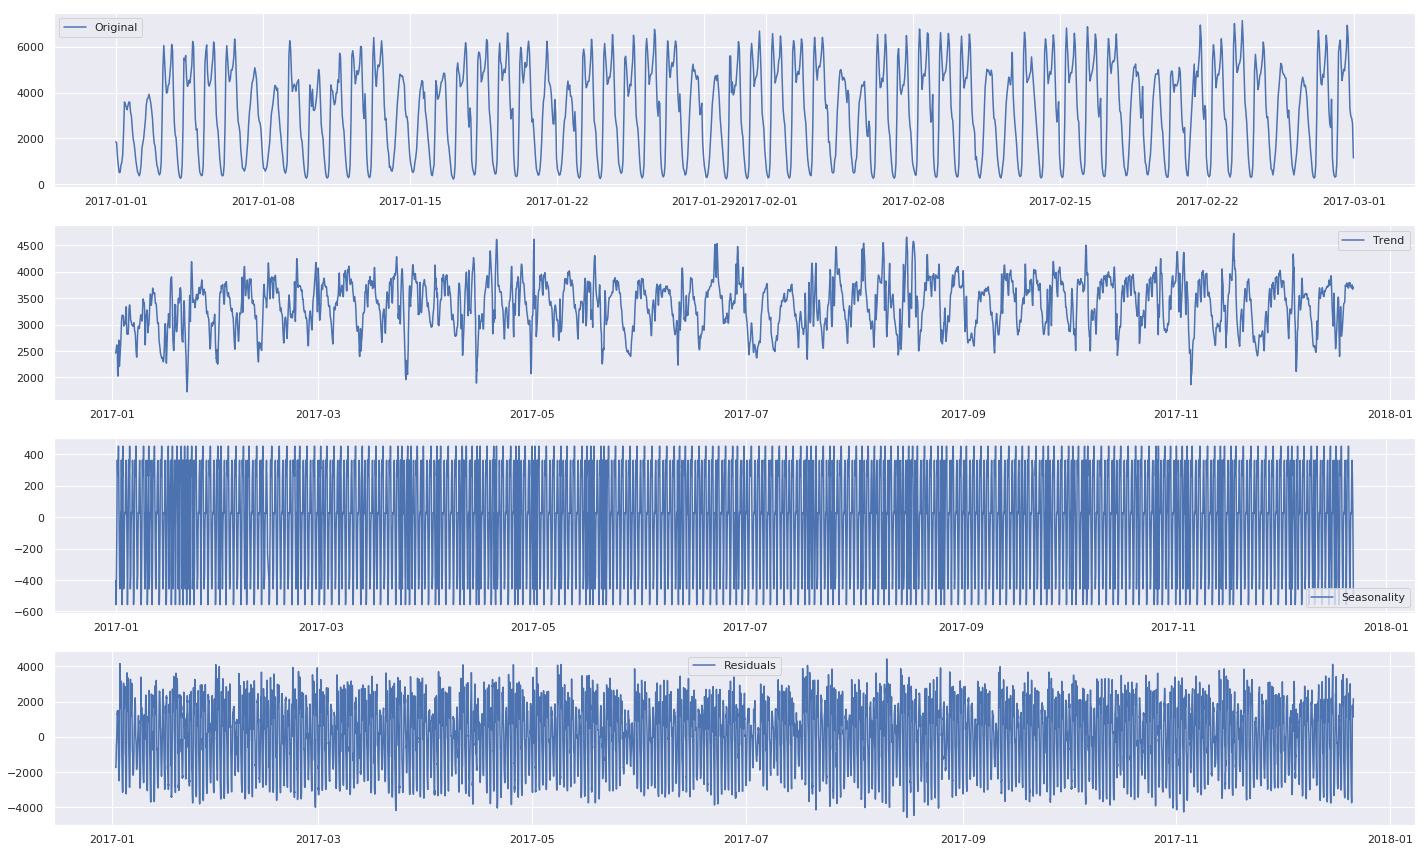

In [28]:
# =============================================================================
# seasonal decomposition why freq =52 ? 
# =============================================================================
df=train['2017']

freq = 52
df=train['TrafficVolume']['2017']
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df,freq=freq)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

df=df['2017-01':'2017-02']
fig, ax = plt.subplots(4,1,figsize=(20,12))
plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Step 3 

##  3-1 Data Quality Issues

In [29]:
# 0-IsHoliday 
#seems to be only annotated for hour 0 of the related day
train['2016-01-01']

IsHoliday    Temp  Rain1h  Snow1h  CloudsAll  \
Time                                                                    
2016-01-01 00:00:00  New Years Day  265.94     0.0     0.0         90   
2016-01-01 00:00:00  New Years Day  265.94     0.0     0.0         90   
2016-01-01 01:00:00           None  266.00     0.0     0.0         90   
2016-01-01 03:00:00           None  266.01     0.0     0.0         90   
2016-01-01 04:00:00           None  264.80     0.0     0.0         90   
2016-01-01 05:00:00           None  264.38     0.0     0.0         90   
2016-01-01 06:00:00           None  263.99     0.0     0.0          1   
2016-01-01 07:00:00           None  264.16     0.0     0.0          1   
2016-01-01 08:00:00           None  264.80     0.0     0.0         75   
2016-01-01 09:00:00           None  265.76     0.0     0.0         90   
2016-01-01 10:00:00           None  267.61     0.0     0.0         40   
2016-01-01 12:00:00           None  269.43     0.0     0.0          1   
2016-01-01 13:00:00           None  271.77     0.0     0.0          1   
2016-01-01 14:00:00           None  271.98     0.0     0.0          1   
2016-01-01 16:00:00           None  271.93     0.0     0.0          1   
2016-01-01 18:00:00           None  269.40     0.0     0.0          1   
2016-01-01 20:00:00           None  267.65     0.0     0.0          1   
2016-01-01 21:00:00           None  266.52     0.0     0.0          1   
2016-01-01 23:00:00           None  265.51     0.0     0.0          1   

                    WeatherMain WeatherDescription  TrafficVolume  
Time                                                               
2016-01-01 00:00:00        Haze               haze           1513  
2016-01-01 00:00:00        Snow         light snow           1513  
2016-01-01 01:00:00        Snow         light snow           1550  
2016-01-01 03:00:00        Snow         light snow            719  
2016-01-01 04:00:00      Clouds    overcast clouds            533  
2016-01-01 05:00:00      Clouds    overcast clouds            586  
2016-01-01 06:00:00       Clear       sky is clear            809  
2016-01-01 07:00:00       Clear       sky is clear            882  
2016-01-01 08:00:00      Clouds      broken clouds           1077  
2016-01-01 09:00:00      Clouds    overcast clouds           1574  
2016-01-01 10:00:00      Clouds   scattered clouds           2059  
2016-01-01 12:00:00       Clear       sky is clear           3206  
2016-01-01 13:00:00       Clear       sky is clear           3498  
2016-01-01 14:00:00       Clear       sky is clear           3453  
2016-01-01 16:00:00       Clear       sky is clear           3359  
2016-01-01 18:00:00       Clear       sky is clear           2899  
2016-01-01 20:00:00       Clear       sky is clear           2134  
2016-01-01 21:00:00       Clear       sky is clear           1845  
2016-01-01 23:00:00       Clear       sky is clear           1280

In [30]:
#some note even annotated ex : 2017-01-01 
train.loc['2017-01-01','IsHoliday']

Time
2017-01-01 00:00:00    None
2017-01-01 01:00:00    None
2017-01-01 02:00:00    None
2017-01-01 03:00:00    None
2017-01-01 04:00:00    None
2017-01-01 05:00:00    None
2017-01-01 06:00:00    None
2017-01-01 07:00:00    None
2017-01-01 08:00:00    None
2017-01-01 09:00:00    None
2017-01-01 10:00:00    None
2017-01-01 11:00:00    None
2017-01-01 12:00:00    None
2017-01-01 13:00:00    None
2017-01-01 14:00:00    None
2017-01-01 15:00:00    None
2017-01-01 16:00:00    None
2017-01-01 17:00:00    None
2017-01-01 18:00:00    None
2017-01-01 19:00:00    None
2017-01-01 20:00:00    None
2017-01-01 21:00:00    None
2017-01-01 22:00:00    None
2017-01-01 23:00:00    None
Name: IsHoliday, dtype: object

In [31]:
#1- Rain1h
#2016-07-11 17:00:00 have rainhour >9000 while surrounding values of rain is 0 ==>error we will put 0 
train.loc['2016-07-11 17','Rain1h']

9831.3

In [32]:
#Temperature with 0 K => impossible
train[train.Temp==0]

IsHoliday  Temp  Rain1h  Snow1h  CloudsAll WeatherMain  \
Time                                                                         
2014-01-31 03:00:00      None   0.0     0.0     0.0          0       Clear   
2014-01-31 04:00:00      None   0.0     0.0     0.0          0       Clear   
2014-01-31 05:00:00      None   0.0     0.0     0.0          0       Clear   
2014-01-31 06:00:00      None   0.0     0.0     0.0          0       Clear   
2014-02-02 03:00:00      None   0.0     0.0     0.0          0       Clear   
2014-02-02 04:00:00      None   0.0     0.0     0.0          0       Clear   
2014-02-02 05:00:00      None   0.0     0.0     0.0          0       Clear   
2014-02-02 06:00:00      None   0.0     0.0     0.0          0       Clear   
2014-02-02 07:00:00      None   0.0     0.0     0.0          0       Clear   
2014-02-02 08:00:00      None   0.0     0.0     0.0          0       Clear   

                    WeatherDescription  TrafficVolume  
Time                                                   
2014-01-31 03:00:00       sky is clear            361  
2014-01-31 04:00:00       sky is clear            734  
2014-01-31 05:00:00       sky is clear           2557  
2014-01-31 06:00:00       sky is clear           5150  
2014-02-02 03:00:00       sky is clear            291  
2014-02-02 04:00:00       sky is clear            284  
2014-02-02 05:00:00       sky is clear            434  
2014-02-02 06:00:00       sky is clear            739  
2014-02-02 07:00:00       sky is clear            962  
2014-02-02 08:00:00       sky is clear           1670

In [33]:
#3- Time series 
train.loc['2017-02-28 17'] ##gives 3 values for one unique hour

IsHoliday    Temp  Rain1h  Snow1h  CloudsAll WeatherMain  \
Time                                                                           
2017-02-28 17:00:00      None  276.91     0.0     0.0         90     Drizzle   
2017-02-28 17:00:00      None  276.91     0.0     0.0         90        Rain   
2017-02-28 17:00:00      None  276.91     0.0     0.0         90        Snow   

                          WeatherDescription  TrafficVolume  
Time                                                         
2017-02-28 17:00:00  light intensity drizzle           6365  
2017-02-28 17:00:00            moderate rain           6365  
2017-02-28 17:00:00               light snow           6365

##  3-2 Data Quality fixes

In [34]:
train = pd.read_csv('https://raw.githubusercontent.com/kevinzous/Forecasting-Projects-/master/Project%202/data/P2train.csv', parse_dates=['Time'],index_col='Time',header=0)
test = pd.read_csv('https://raw.githubusercontent.com/kevinzous/Forecasting-Projects-/master/Project%202/data/P2test.csv', parse_dates=['Time'],index_col='Time',header=0)
test_index = pd.read_csv('https://raw.githubusercontent.com/kevinzous/Forecasting-Projects-/master/Project%202/data/P2test_index.csv', header=0)

##Fixes 
#0- Holiday
index= train[train.IsHoliday!='None'].index
for i in index:
    ##print(str(i)[0:10])
    train.loc[str(i)[0:10],'IsHoliday']='Holiday' ##take only the 10 first char ie the day and not hour
#some note even annotated ex : 2017-01-01 
train.loc['2017-01-01','IsHoliday']='Holiday'
train['IsHoliday']= np.where(train['IsHoliday']=='None', 0,1)

#1- Rain1h
train.loc['2016-07-11 17','Rain1h']=0

#2- Temp
# We'll replace 0 with nan and apply interpolation
train['Temp']=train['Temp'].replace(0, np.nan).interpolate()


#add extra time features 
train['date'] = [train.index[i].date() for i in range(0,len(train))]
train['hour']=train.index.hour
train['day_name']=train.index.day_name()
#dayofweek : s0 = monday and 6 = sunday
train['dayofweek']=train.index.dayofweek
train['dayofmonth']=train.index.day
train['dayofyear']=train.index.dayofyear

train['weekofyear']=train.index.weekofyear
train['monthofyear']=train.index.month

train['year']=train1.index.year-2012


#count by year / month 
print(train['2017']['monthofyear'].value_counts())
print()
print('nber of days with points striclty inferior than 24: {} '.format((train.groupby(['year','monthofyear','dayofmonth']).size()<24).sum()))

#count number of values by day 
train[['date','TrafficVolume']].groupby(by='date').count().sort_values(by='TrafficVolume') #values ranges from 81 to 1
train.loc['2012-12-16'] ## 81 values
print(train.loc['2012-12-16 10:00']) ##for a same hour, only the weathermain and weather description changes, Temp and Traffic vol remain the same 

##same for test set : 
test['date'] = [test.index[i].date() for i in range(0,len(test))]
#count number of values by day 
test[['date','TrafficVolume']].groupby(by='date').count().sort_values(by='TrafficVolume') #values ranges from 81 to 1


1     1026
4      963
8      960
5      952
10     928
3      865
7      850
11     844
6      817
9      805
2      714
12     626
Name: monthofyear, dtype: int64

nber of days with points striclty inferior than 24: 453 
                     IsHoliday    Temp  Rain1h  Snow1h  CloudsAll WeatherMain  \
Time                                                                            
2012-12-16 10:00:00          0  275.26     0.0     0.0         90        Rain   
2012-12-16 10:00:00          0  275.26     0.0     0.0         90        Mist   
2012-12-16 10:00:00          0  275.26     0.0     0.0         90     Drizzle   
2012-12-16 10:00:00          0  275.26     0.0     0.0         90     Drizzle   

                          WeatherDescription  TrafficVolume        date  hour  \
Time                                                                            
2012-12-16 10:00:00               light rain           3021  2012-12-16    10   
2012-12-16 10:00:00                     mist    

TrafficVolume
date                     
2017-12-22              7
2018-03-24             18
2018-03-16             23
2018-03-15             23
2018-08-23             23
...                   ...
2018-04-15             60
2018-08-24             61
2018-09-04             61
2018-09-20             64
2018-04-14             68

[283 rows x 1 columns]

In [35]:
train.IsHoliday

Time
2012-10-02 09:00:00    0
2012-10-02 10:00:00    0
2012-10-02 11:00:00    0
2012-10-02 12:00:00    0
2012-10-02 13:00:00    0
                      ..
2017-12-22 12:00:00    0
2017-12-22 13:00:00    0
2017-12-22 14:00:00    0
2017-12-22 15:00:00    0
2017-12-22 16:00:00    0
Name: IsHoliday, Length: 40000, dtype: int64

In [36]:
#Cleaning and resampling time 
##a-resample to have a clean data every hour 
##b-for multiple entries in an hour, took first values (impact on WeatherMain and Weather Description)
##c-fill the nan by interpolation
train_cleaned=train.resample('H').first().interpolate(limit=3) ## max consecutive nan filled by interpolation = 3 
print('nber of rows before resample: {}'.format(train.shape[0]))
print('nber of rows after resample: {}'.format(train_cleaned.shape[0]))
print()
print('number of nan after interpolation: ')
train_cleaned.isnull().sum()

nber of rows before resample: 40000
nber of rows after resample: 45776

number of nan after interpolation: 


IsHoliday              8794
Temp                   8794
Rain1h                 8794
Snow1h                 8794
CloudsAll              8794
WeatherMain           11956
WeatherDescription    11956
TrafficVolume          8794
date                  11956
hour                   8794
day_name              11956
dayofweek              8794
dayofmonth             8794
dayofyear              8794
weekofyear             8794
monthofyear            8794
year                   8794
dtype: int64

## 3-2 Linear regression with features 

In [37]:
feature_set=['IsHoliday', 'Temp', 'Rain1h', 'Snow1h', 'CloudsAll', 'C(hour)','C(dayofweek)','C(monthofyear)','year']
model=modelFitting(y, feature_set, train)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TrafficVolume   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     4599.
Date:                Sat, 16 Nov 2019   Prob (F-statistic):               0.00
Time:                        14:40:09   Log-Likelihood:            -3.2383e+05
No. Observations:               40000   AIC:                         6.478e+05
Df Residuals:                   39953   BIC:                         6.482e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -918.4260    183.223     -5.013      0.000   -1277.547    -559.305
C(hour)[T.1]          -306.9089     27.218    -11.276      0.000    -360.257    -253.561
C(hour)[T.2]          -445.2500     27.271    -16.327      0.000    -498.702    -391.798
C(hour)[T.3]          -464.0418     27.339    -16.974      0.000    -517.627    -410.457
C(hour)[T.4]          -125.2311     27.100     -4.621      0.000    -178.349     -72.114
C(hour)[T.5]          1262.7334     27.275     46.296      0.000    1209.273    1316.194
C(hour)[T.6]          3343.1401     27.165    123.070      0.000    3289.897    3396.383
C(hour)[T.7]          3934.0592     27.213    144.568      0.000    3880.722    3987.396
C(hour)[T.8]          3792.7942     27.154    139.678      0.000    3739.572    3846.016
C(hour)[T.9]          3565.2759     27.417    130.040      0.000    3511.538    3619.013
C(hour)[T.10]         3357.4382     27.157    123.631      0.000    3304.210    3410.667
C(hour)[T.11]         3638.4166     27.658    131.552      0.000    3584.207    3692.626
C(hour)[T.12]         3878.7580     27.628    140.392      0.000    3824.606    3932.910
C(hour)[T.13]         3887.4799     27.879    139.441      0.000    3832.836    3942.123
C(hour)[T.14]         4095.0978     27.662    148.039      0.000    4040.879    4149.317
C(hour)[T.15]         4393.5822     27.811    157.982      0.000    4339.073    4448.092
C(hour)[T.16]         4817.9195     27.607    174.520      0.000    4763.810    4872.029
C(hour)[T.17]         4486.8789     27.799    161.405      0.000    4432.393    4541.365
C(hour)[T.18]         3414.5829     27.590    123.761      0.000    3360.506    3468.660
C(hour)[T.19]         2422.9198     27.630     87.693      0.000    2368.765    2477.074
C(hour)[T.20]         1986.8096     27.505     72.234      0.000    1932.899    2040.720
C(hour)[T.21]         1827.4889     27.455     66.563      0.000    1773.676    1881.302
C(hour)[T.22]         1364.2600     27.393     49.803      0.000    1310.569    1417.951
C(hour)[T.23]          626.0670     27.205     23.013      0.000     572.744     679.390
C(dayofweek)[T.1]      114.2119     15.019      7.604      0.000      84.774     143.650
C(dayofweek)[T.2]      168.2739     14.901     11.292      0.000     139.067     197.481
C(dayofweek)[T.3]      255.8532     14.881     17.193      0.000     226.685     285.021
C(dayofweek)[T.4]      244.1873     14.958     16.325      0.000     214.869     273.506
C(dayofweek)[T.5]     -636.1913     15.069    -42.217      0.000    -665.728    -606.655
C(dayofweek)[T.6]    -1051.7229     14.988    -70.169      0.000   -1081.100   -1022.345
C(monthofyear)[T.2]    149.3541     20.889      7.150      0.000     108.411     190.297
C(monthofyear)[T.3]    215.3334     21.171     10.171    

In [38]:
from statsmodels.stats import outliers_influence  #for VIF
for i in range(len(model.model.exog_names)):
     print('VIF for '+model.model.exog_names[i]+':'+str( outliers_influence.variance_inflation_factor(model.model.exog, i)))

VIF for Intercept:2128.1690358091137
VIF for C(hour)[T.1]:1.9154283436155712
VIF for C(hour)[T.2]:1.9099215003759358
VIF for C(hour)[T.3]:1.9031849849853324
VIF for C(hour)[T.4]:1.9350789823411483
VIF for C(hour)[T.5]:1.9148696871265214
VIF for C(hour)[T.6]:1.9314175860455884
VIF for C(hour)[T.7]:1.9264534011978032
VIF for C(hour)[T.8]:1.932039123452146
VIF for C(hour)[T.9]:1.8933043475203215
VIF for C(hour)[T.10]:1.9282073906859771
VIF for C(hour)[T.11]:1.871029120431585
VIF for C(hour)[T.12]:1.8859489548395008
VIF for C(hour)[T.13]:1.862555922598167
VIF for C(hour)[T.14]:1.9028810072025124
VIF for C(hour)[T.15]:1.8861568638967747
VIF for C(hour)[T.16]:1.9129783385590835
VIF for C(hour)[T.17]:1.8845609431223296
VIF for C(hour)[T.18]:1.9040238310428763
VIF for C(hour)[T.19]:1.8861502065082714
VIF for C(hour)[T.20]:1.8923161360491043
VIF for C(hour)[T.21]:1.8909270157259057
VIF for C(hour)[T.22]:1.894386338489267
VIF for C(hour)[T.23]:1.9168277122116015
VIF for C(dayofweek)[T.1]:1.72609

In [39]:
#forward=forward(y, feature_set, train)
#returns below 
feature_set=['IsHoliday', 'Temp', 'Rain1h', 'Snow1h', 'CloudsAll', 'C(hour)','C(dayofweek)','C(monthofyear)','year']
#forward_interaction=forward_interaction(y, feature_set, train)

##returns
feature_set_fwdinter=['C(hour):C(dayofweek)', 'C(hour):C(monthofyear)', 'C(dayofweek):C(monthofyear)',
             'C(monthofyear):year', 'Rain1h:C(dayofweek)', 'Temp:C(monthofyear)', 'CloudsAll:C(monthofyear)',
             'Rain1h:C(hour)', 'Rain1h:C(monthofyear)', 'Snow1h:C(hour)', 'C(dayofweek):year', 'C(hour):year',
             'Rain1h:year', 'Temp:C(dayofweek)', 'IsHoliday:C(monthofyear)', 'Temp:C(hour)',
             'CloudsAll:C(dayofweek)', 'CloudsAll:year', 'Temp:Rain1h', 'Temp:year']
forward_interaction_model=modelFitting(y, feature_set_fwdinter, train)
forward_interaction_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TrafficVolume   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     1203.
Date:                Sat, 16 Nov 2019   Prob (F-statistic):               0.00
Time:                        14:40:27   Log-Likelihood:            -2.9927e+05
No. Observations:               40000   AIC:                         5.999e+05
Df Residuals:                   39329   BIC:                         6.056e+05
Df Model:                         670                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                              -2601.9105    643.737     -4.042      0.000   -3863.650   -1340.171
C(dayofweek)[T.1]                        599.0471    363.425      1.648      0.099    -113.275    1311.369
C(dayofweek)[T.2]                        584.4470    385.704      1.515      0.130    -171.543    1340.437
C(dayofweek)[T.3]                        370.6288    384.696      0.963      0.335    -383.384    1124.642
C(dayofweek)[T.4]                       1675.0818    376.094      4.454      0.000     937.929    2412.235
C(dayofweek)[T.5]                       3091.0832    369.727      8.360      0.000    2366.409    3815.757
C(dayofweek)[T.6]                       1762.8479    359.450      4.904      0.000    1058.318    2467.378
C(hour)[T.1]:C(dayofweek)[0]              11.5453    707.124      0.016      0.987   -1374.434    1397.525
C(hour)[T.2]:C(dayofweek)[0]             -64.3376    700.691     -0.092      0.927   -1437.708    1309.033
C(hour)[T.3]:C(dayofweek)[0]             -57.4452    706.086     -0.081      0.935   -1441.390    1326.500
C(hour)[T.4]:C(dayofweek)[0]             254.5189    695.773      0.366      0.715   -1109.214    1618.251
C(hour)[T.5]:C(dayofweek)[0]            1360.6061    699.067      1.946      0.052      -9.582    2730.794
C(hour)[T.6]:C(dayofweek)[0]            3043.2612    693.029      4.391      0.000    1684.908    4401.615
C(hour)[T.7]:C(dayofweek)[0]            3981.5549    704.167      5.654      0.000    2601.369    5361.740
C(hour)[T.8]:C(dayofweek)[0]            3468.7911    693.799      5.000      0.000    2108.929    4828.654
C(hour)[T.9]:C(dayofweek)[0]            2662.2512    712.652      3.736      0.000    1265.435    4059.067
C(hour)[T.10]:C(dayofweek)[0]           2170.6900    702.639      3.089      0.002     793.500    3547.880
C(hour)[T.11]:C(dayofweek)[0]           2036.6493    710.374      2.867      0.004     644.298    3429.000
C(hour)[T.12]:C(dayofweek)[0]           2254.3057    705.535      3.195      0.001     871.440    3637.171
C(hour)[T.13]:C(dayofweek)[0]           2826.2864    710.025      3.981      0.000    1434.620    4217.953
C(hour)[T.14]:C(dayofweek)[0]           2501.5514    695.673      3.596      0.000    1138.016    3865.087
C(hour)[T.15]:C(dayofweek)[0]           3060.9420    702.944      4.354      0.000    1683.156    4438.728
C(hour)[T.16]:C(dayofweek)[0]           3235.8583    689.091      4.696      0.000    1885.224    4586.493
C(hour)[T.17]:C(dayofweek)[0]           3184.7642    700.026      4.549      0.000    1812.697    4556.832
C(hour)[T.18]:C(dayofweek)[0]           1056.3562    702.099      1.505      0.132    -319.775    2432.487
C(hour)[T.19]:C(dayofweek)[0]            712.2110    709.430      1.004      0.315    -

In [40]:
'''feature_set=['IsHoliday', 'Temp', 'Rain1h', 'Snow1h', 'CloudsAll', 'C(hour)','C(dayofweek)','C(monthofyear)','year']
model = forward(y, feature_set,train, criterion="AIC")'''
feature_set_fwd= ['C(hour)', 'C(dayofweek)', 'C(monthofyear)', 'Temp', 'CloudsAll', 'year', 'Snow1h']
model=modelFitting(y, feature_set_fwd, train)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TrafficVolume   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     4596.
Date:                Sat, 16 Nov 2019   Prob (F-statistic):               0.00
Time:                        14:40:29   Log-Likelihood:            -3.2459e+05
No. Observations:               40000   AIC:                         6.493e+05
Df Residuals:                   39955   BIC:                         6.497e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -989.0107    186.712     -5.297      0.000   -1354.970    -623.051
C(hour)[T.1]          -302.9720     27.738    -10.923      0.000    -357.338    -248.606
C(hour)[T.2]          -441.7152     27.791    -15.894      0.000    -496.187    -387.243
C(hour)[T.3]          -463.9723     27.861    -16.653      0.000    -518.580    -409.365
C(hour)[T.4]          -123.4371     27.618     -4.469      0.000    -177.569     -69.305
C(hour)[T.5]          1262.7077     27.796     45.428      0.000    1208.227    1317.189
C(hour)[T.6]          3342.0900     27.682    120.730      0.000    3287.832    3396.348
C(hour)[T.7]          3935.2679     27.732    141.904      0.000    3880.913    3989.623
C(hour)[T.8]          3794.9338     27.672    137.139      0.000    3740.696    3849.172
C(hour)[T.9]          3569.5326     27.940    127.758      0.000    3514.770    3624.295
C(hour)[T.10]         3361.8201     27.674    121.478      0.000    3307.578    3416.062
C(hour)[T.11]         3640.7360     28.186    129.170      0.000    3585.492    3695.980
C(hour)[T.12]         3881.9662     28.154    137.883      0.000    3826.784    3937.149
C(hour)[T.13]         3889.8910     28.411    136.916      0.000    3834.205    3945.577
C(hour)[T.14]         4097.1032     28.189    145.345      0.000    4041.853    4152.354
C(hour)[T.15]         4398.7867     28.339    155.221      0.000    4343.242    4454.332
C(hour)[T.16]         4819.7653     28.133    171.319      0.000    4764.624    4874.907
C(hour)[T.17]         4491.3616     28.329    158.544      0.000    4435.837    4546.887
C(hour)[T.18]         3416.7354     28.114    121.532      0.000    3361.632    3471.839
C(hour)[T.19]         2426.4765     28.156     86.179      0.000    2371.289    2481.664
C(hour)[T.20]         1988.8804     28.029     70.957      0.000    1933.942    2043.819
C(hour)[T.21]         1826.9230     27.979     65.295      0.000    1772.083    1881.763
C(hour)[T.22]         1365.1487     27.916     48.902      0.000    1310.433    1419.864
C(hour)[T.23]          626.7873     27.724     22.608      0.000     572.447     681.128
C(dayofweek)[T.1]      202.9028     15.123     13.417      0.000     173.262     232.544
C(dayofweek)[T.2]      259.2549     14.999     17.285      0.000     229.857     288.653
C(dayofweek)[T.3]      314.2118     15.086     20.828      0.000     284.643     343.780
C(dayofweek)[T.4]      329.1983     15.082     21.828      0.000     299.638     358.758
C(dayofweek)[T.5]     -535.8574     15.125    -35.428      0.000    -565.503    -506.211
C(dayofweek)[T.6]     -956.9349     15.061    -63.536      0.000    -986.455    -927.414
C(monthofyear)[T.2]    174.6542     21.277      8.209      0.000     132.951     216.358
C(monthofyear)[T.3]    272.6175     21.520     12.668    

In [41]:
feature_set=['IsHoliday', 'Temp', 'Rain1h', 'Snow1h', 'CloudsAll', 'C(hour)','C(dayofweek)','C(monthofyear)','year']
model_bw=backward(y, feature_set,train, criterion="AIC")
##returns ['IsHoliday', 'Rain1h']
model_bw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TrafficVolume   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     4599.
Date:                Sat, 16 Nov 2019   Prob (F-statistic):               0.00
Time:                        14:40:37   Log-Likelihood:            -3.2383e+05
No. Observations:               40000   AIC:                         6.478e+05
Df Residuals:                   39953   BIC:                         6.482e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -918.4260    183.223     -5.013      0.000   -1277.547    -559.305
C(hour)[T.1]          -306.9089     27.218    -11.276      0.000    -360.257    -253.561
C(hour)[T.2]          -445.2500     27.271    -16.327      0.000    -498.702    -391.798
C(hour)[T.3]          -464.0418     27.339    -16.974      0.000    -517.627    -410.457
C(hour)[T.4]          -125.2311     27.100     -4.621      0.000    -178.349     -72.114
C(hour)[T.5]          1262.7334     27.275     46.296      0.000    1209.273    1316.194
C(hour)[T.6]          3343.1401     27.165    123.070      0.000    3289.897    3396.383
C(hour)[T.7]          3934.0592     27.213    144.568      0.000    3880.722    3987.396
C(hour)[T.8]          3792.7942     27.154    139.678      0.000    3739.572    3846.016
C(hour)[T.9]          3565.2759     27.417    130.040      0.000    3511.538    3619.013
C(hour)[T.10]         3357.4382     27.157    123.631      0.000    3304.210    3410.667
C(hour)[T.11]         3638.4166     27.658    131.552      0.000    3584.207    3692.626
C(hour)[T.12]         3878.7580     27.628    140.392      0.000    3824.606    3932.910
C(hour)[T.13]         3887.4799     27.879    139.441      0.000    3832.836    3942.123
C(hour)[T.14]         4095.0978     27.662    148.039      0.000    4040.879    4149.317
C(hour)[T.15]         4393.5822     27.811    157.982      0.000    4339.073    4448.092
C(hour)[T.16]         4817.9195     27.607    174.520      0.000    4763.810    4872.029
C(hour)[T.17]         4486.8789     27.799    161.405      0.000    4432.393    4541.365
C(hour)[T.18]         3414.5829     27.590    123.761      0.000    3360.506    3468.660
C(hour)[T.19]         2422.9198     27.630     87.693      0.000    2368.765    2477.074
C(hour)[T.20]         1986.8096     27.505     72.234      0.000    1932.899    2040.720
C(hour)[T.21]         1827.4889     27.455     66.563      0.000    1773.676    1881.302
C(hour)[T.22]         1364.2600     27.393     49.803      0.000    1310.569    1417.951
C(hour)[T.23]          626.0670     27.205     23.013      0.000     572.744     679.390
C(dayofweek)[T.1]      114.2119     15.019      7.604      0.000      84.774     143.650
C(dayofweek)[T.2]      168.2739     14.901     11.292      0.000     139.067     197.481
C(dayofweek)[T.3]      255.8532     14.881     17.193      0.000     226.685     285.021
C(dayofweek)[T.4]      244.1873     14.958     16.325      0.000     214.869     273.506
C(dayofweek)[T.5]     -636.1913     15.069    -42.217      0.000    -665.728    -606.655
C(dayofweek)[T.6]    -1051.7229     14.988    -70.169      0.000   -1081.100   -1022.345
C(monthofyear)[T.2]    149.3541     20.889      7.150      0.000     108.411     190.297
C(monthofyear)[T.3]    215.3334     21.171     10.171    

In [42]:
#model selection :
from sklearn.model_selection import train_test_split
def crossvalidation(feature_set,train_X,train_y,y):
    '''feature_set : list of features for linear regresssion 
    train_X= data frame with no y
    train_y= data frame with y
    y= string '''

    X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
    X_train[y]=y_train
    model=modelFitting(y, feature_set, X_train)
    train_err=sum(np.abs(model.fittedvalues - y_train))/ len(y_train)
    train_mse=sum((model.fittedvalues - y_train)**2)/ len(y_train)
                  
    test_err=sum(np.abs(model.predict(X_test) - y_test))/ len(y_test)
    test_mse=sum((model.predict(X_test) - y_test)**2)/ len(y_test)
    print(feature_set)
    print('train errors = {} {}'.format(train_err, train_mse))
    print('test errors = {} {} '.format(test_err, test_mse))
    print()     
    #return train_err, train_mse, test_err, test_mse         


#Full model 
crossvalidation(['IsHoliday', 'Temp', 'Rain1h', 'Snow1h', 'CloudsAll', 'C(WeatherMain)', 'C(hour)', 'C(dayofweek)', 'C(monthofyear)', 'year']
 ,train,train['TrafficVolume'],'TrafficVolume')   
#Full model without WeatherMain
crossvalidation(feature_set,train,train['TrafficVolume'],'TrafficVolume')
#Forward selection
crossvalidation(feature_set_fwd,train,train['TrafficVolume'],'TrafficVolume')


#Full model with interaction
X=feature_set
cand_2Inter = []
for p1 in X:
    for p2 in X:
        if p1 == p2:
            cand_2Inter.append(p1);
        else:
            cand_2Inter.append(p1+':'+p2)
crossvalidation(cand_2Inter,train,train['TrafficVolume'],'TrafficVolume')
#Forward selection with interaction
crossvalidation(feature_set_fwdinter,train,train['TrafficVolume'],'TrafficVolume')

/home/zhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


['IsHoliday', 'Temp', 'Rain1h', 'Snow1h', 'CloudsAll', 'C(WeatherMain)', 'C(hour)', 'C(dayofweek)', 'C(monthofyear)', 'year']
train errors = 588.5508494283441 636275.3068012127
test errors = 576.3728850716025 602466.8862343946 

['IsHoliday', 'Temp', 'Rain1h', 'Snow1h', 'CloudsAll', 'C(hour)', 'C(dayofweek)', 'C(monthofyear)', 'year']
train errors = 588.9197030226899 637213.3088453023
test errors = 576.604289032275 603000.943621953 

['C(hour)', 'C(dayofweek)', 'C(monthofyear)', 'Temp', 'CloudsAll', 'year', 'Snow1h']
train errors = 589.1212075689367 662371.0001789349
test errors = 577.8080855863769 624088.2412944954 

['IsHoliday', 'IsHoliday:Temp', 'IsHoliday:Rain1h', 'IsHoliday:Snow1h', 'IsHoliday:CloudsAll', 'IsHoliday:C(hour)', 'IsHoliday:C(dayofweek)', 'IsHoliday:C(monthofyear)', 'IsHoliday:year', 'Temp:IsHoliday', 'Temp', 'Temp:Rain1h', 'Temp:Snow1h', 'Temp:CloudsAll', 'Temp:C(hour)', 'Temp:C(dayofweek)', 'Temp:C(monthofyear)', 'Temp:year', 'Rain1h:IsHoliday', 'Rain1h:Temp', 'Rai

In [43]:
y='TrafficVolume'
model=modelFitting(y, feature_set_fwdinter, train)

##compute the variance not explained 
train['error']=train.TrafficVolume-model.predict(train)
train['predict']=model.predict(train)

In [44]:
print('mse')
print((train.error**2).mean())
print('mae')
print( np.abs(train.error).mean())

mse
184515.19035391606
mae
265.14242816458835


### Step 1 — Stationarity Check (trend or seasonality component)  before we can use ARIMA to forecast

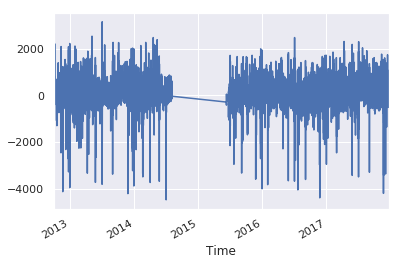

In [45]:
train.error.plot()

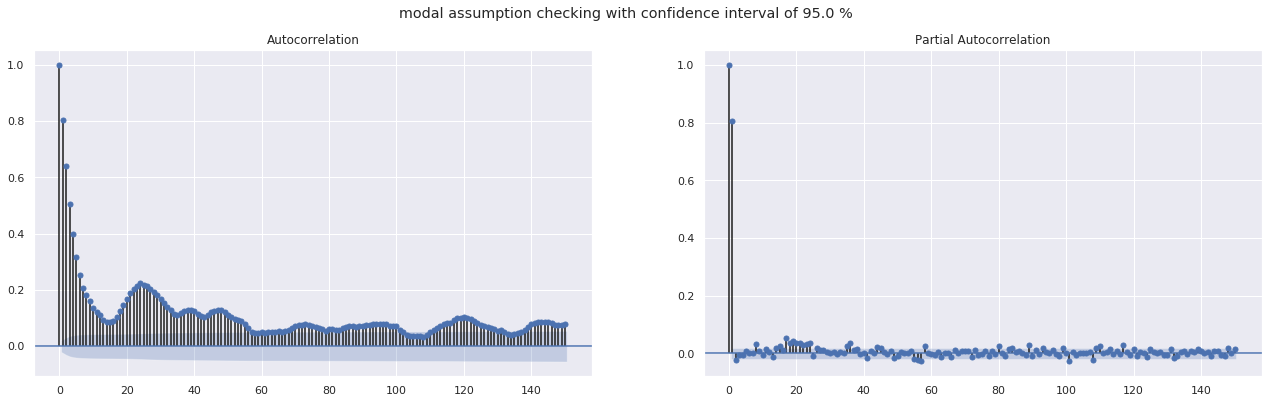

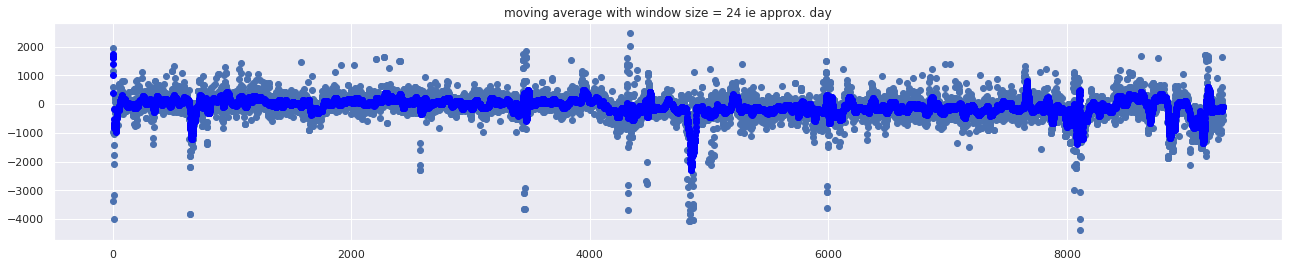

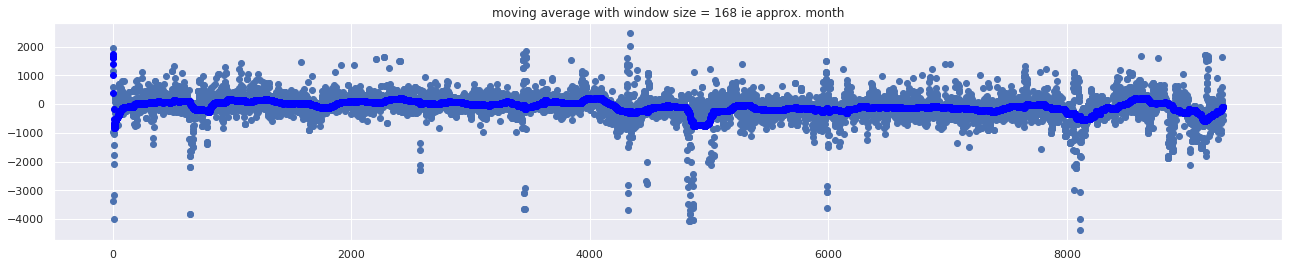

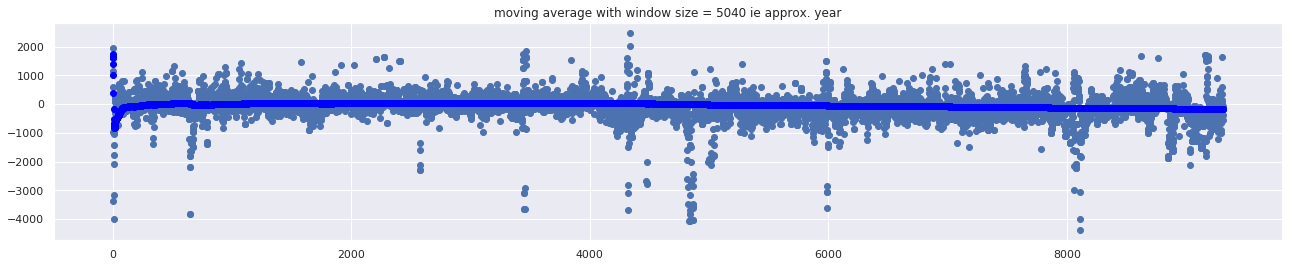

In [46]:
df= train
y='error'

## seasonal testing
alpha=0.05 # 95 % confidence intervals 
lags =150
#24*7=168
#168*30=5040
df =df['2016']
fig, ax = plt.subplots(1,2,figsize=(22,6))
fig.suptitle('modal assumption checking with confidence interval of {} % '.format((1-alpha)*100))
fig = sgt.plot_acf(df[y], ax=ax[0], lags=lags, alpha=alpha, unbiased=True)
fig = sgt.plot_pacf(df[y], ax=ax[1], lags=lags, alpha=alpha, method='ols')

## trend testing
wins =[24,24*7,24*7*30]
wins_exp = {24 : 'approx. day',24*7 :'approx. month', 24*7*30 : 'approx. year'}
for win in wins :
    fig, ax = plt.subplots(1,1,figsize=(22,4))
    ma = df[y].rolling(window=win, min_periods=0, center=False)
    ax.scatter(x=range(0,df.shape[0]), y=df[y])
    ax.scatter(x=range(0,df.shape[0]), y=ma.mean(), color='blue')
    ax.title.set_text('moving average with window size = {} ie {}'.format(win,wins_exp[win]))

### Step 2 — Make the series stationary : Differencing, Log...


In [47]:
df= train
y='error'
diff= df[y] - df[y].shift(1);  ## we compare Y(i) and L(i-1)
diff.dropna(inplace=True)


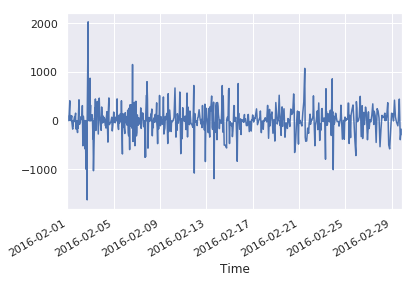

In [48]:
diff['2016-02'].plot()

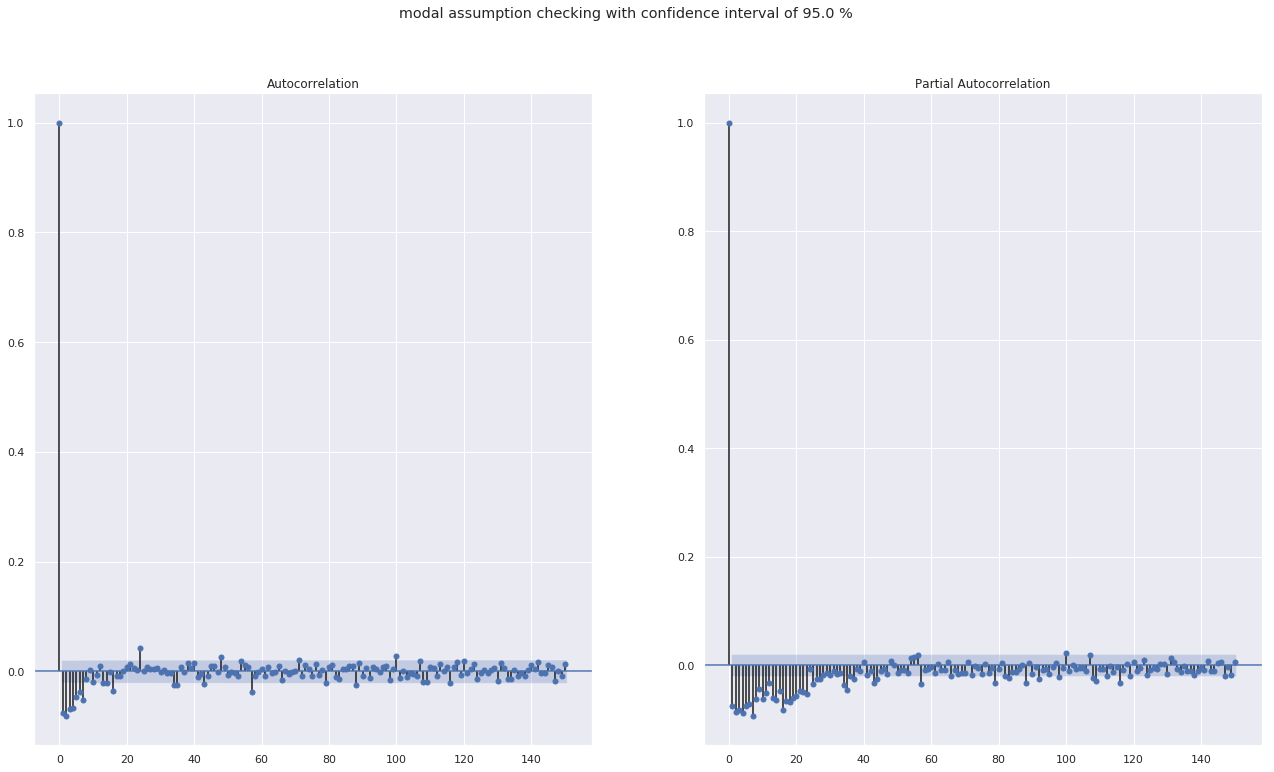

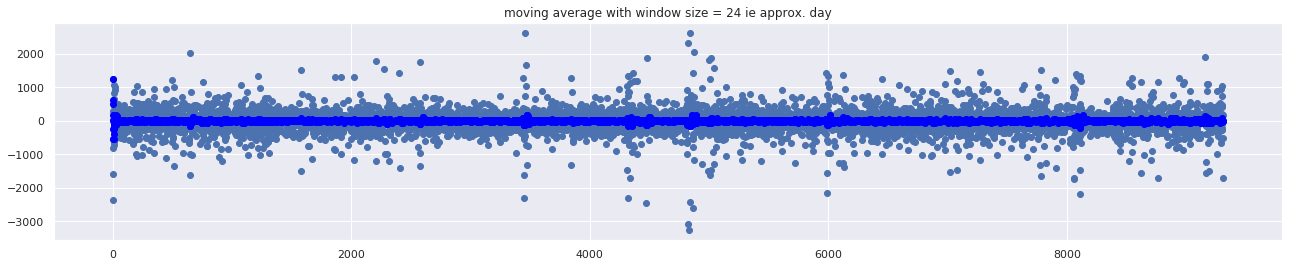

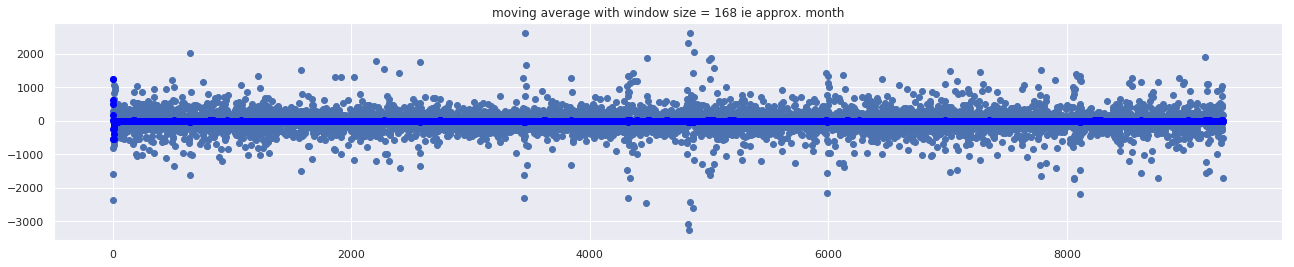

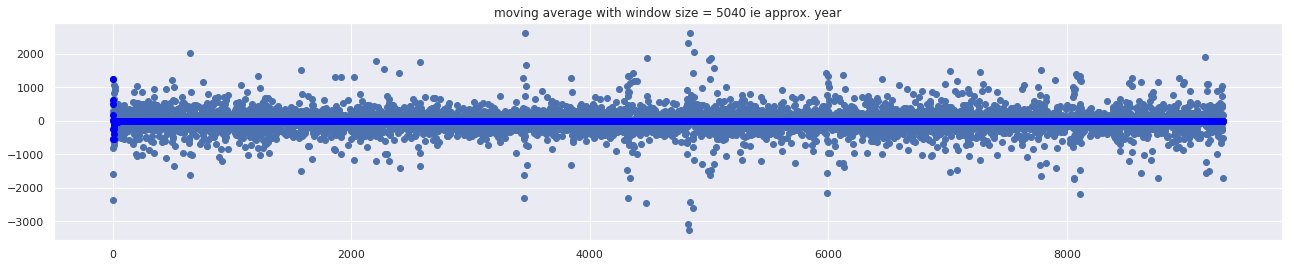

In [49]:
## seasonal testing
alpha=0.05 # 95 % confidence intervals 
lags =150
#24*7=168
#168*30=5040
diff=diff['2016']
fig, ax = plt.subplots(1,2,figsize=(22,12))
fig.suptitle('modal assumption checking with confidence interval of {} % '.format((1-alpha)*100))
fig = sgt.plot_acf(diff, ax=ax[0], lags=lags, alpha=alpha, unbiased=True)
fig = sgt.plot_pacf(diff, ax=ax[1], lags=lags, alpha=alpha, method='ols')

## trend testing
wins =[24,24*7,24*7*30]
wins_exp = {24 : 'approx. day',24*7 :'approx. month', 24*7*30 : 'approx. year'}
for win in wins :
    fig, ax = plt.subplots(1,1,figsize=(22,4))
    ma = diff.rolling(window=win, min_periods=0, center=False)
    ax.scatter(x=range(0,diff.shape[0]), y=diff)
    ax.scatter(x=range(0,diff.shape[0]), y=ma.mean(), color='blue')
    ax.title.set_text('moving average with window size = {} ie {}'.format(win,wins_exp[win]))

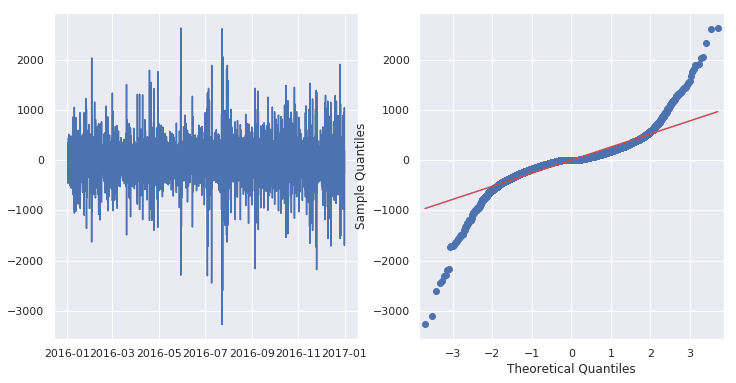

In [50]:
import scipy.stats as stats
res = diff
res = res[24:,]

fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(res)
fig = sm.qqplot(res, stats.distributions.norm, line='r', ax=ax[1]) 

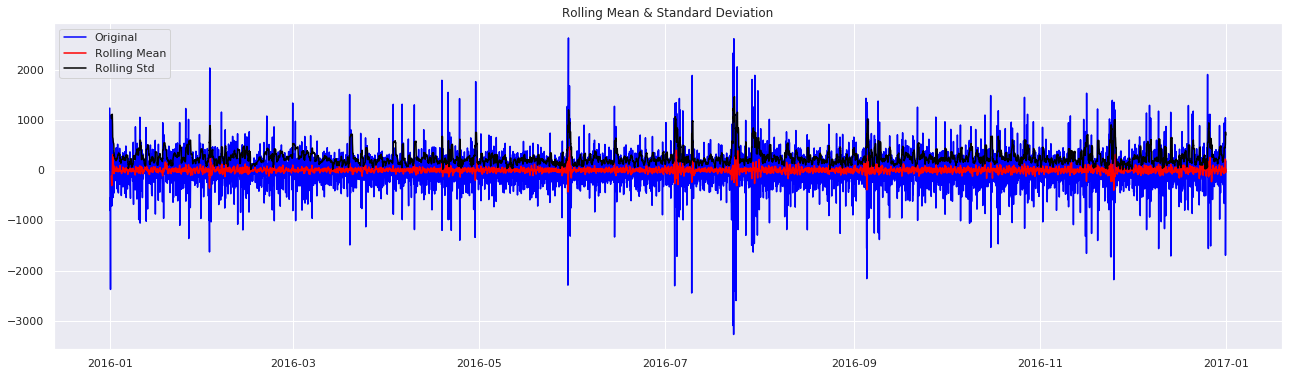

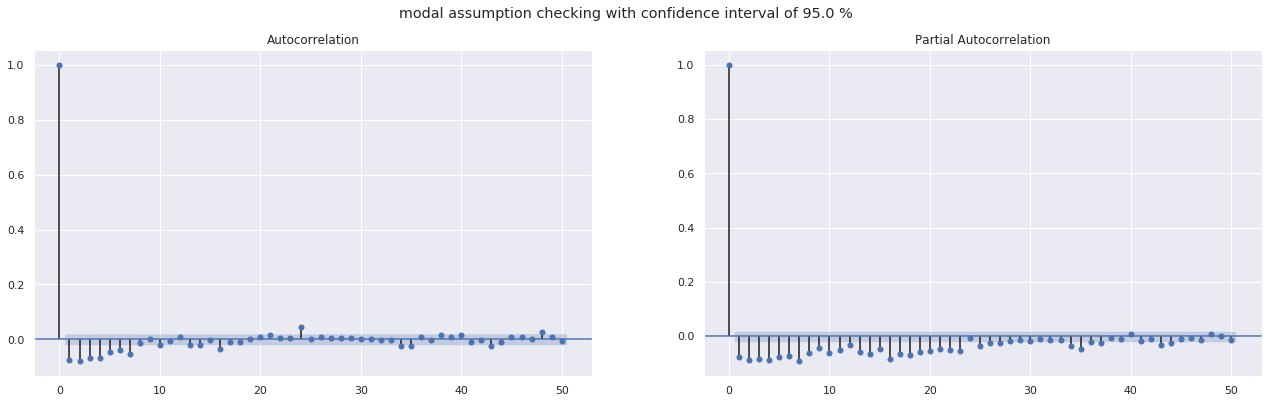

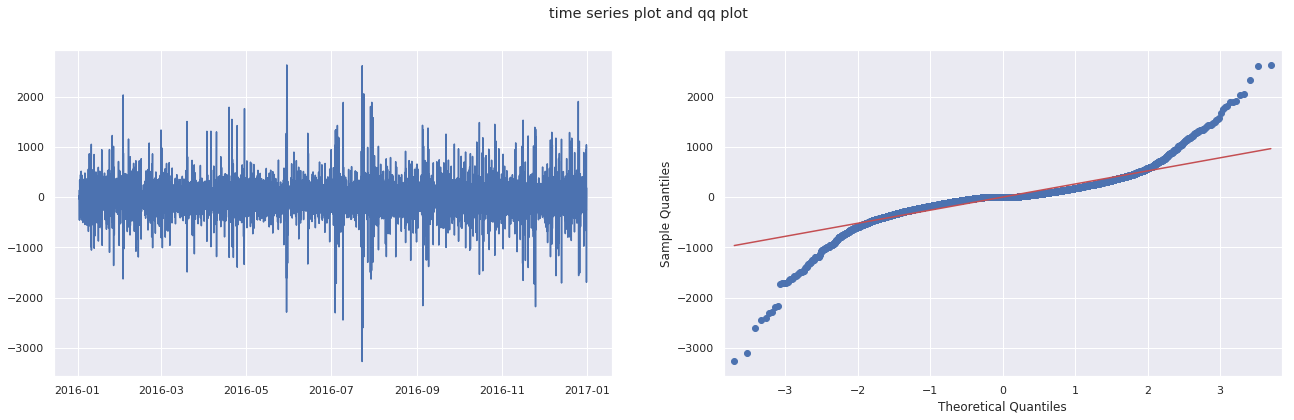

In [81]:
def test_arima(timeseries,window,lags_corr=50,alpha_corr=0.05):
    def test_stationarity(timeseries,window=12):
        #Determing rolling statistics
        rolmean = timeseries.rolling(window=window).mean()
        rolstd = timeseries.rolling(window=window).std()
        #Plot rolling statistics:
        plt.figure(figsize=(22,6))
        orig = plt.plot(timeseries, color='blue',label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block=False)
    
    test_stationarity(timeseries,window=12)
    
    def test_correlation_plot(timeseries,lags=lags_corr, alpha=alpha_corr):
        timeseries=timeseries['2016'] ##(-^-)##
        fig, ax = plt.subplots(1,2,figsize=(22,6))
        fig.suptitle('modal assumption checking with confidence interval of {} % '.format((1-alpha)*100)) 
        fig = sgt.plot_acf(timeseries, ax=ax[0], lags=lags, alpha=alpha, unbiased=True)
        fig = sgt.plot_pacf(timeseries, ax=ax[1], lags=lags, alpha=alpha, method='ols')
        
    test_correlation_plot(timeseries)
    
    def test_diagnostic_plot(timeseries):
        #time series plot
        fig, ax = plt.subplots(1,2,figsize=(22,6))
        fig.suptitle('time series plot and qq plot')
        ax[0].plot(timeseries)
        #qqplot
        fig = sm.qqplot(timeseries, stats.distributions.norm, line='r', ax=ax[1])
        
    test_diagnostic_plot(timeseries[24:,]) ##(-^-)##

test_arima(diff,12)

In [67]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(res, order=(2,1,5))  #  p, d and q
#SARIMAX
model_fit = model.fit(disp=0,start_ar_lags=13)
print(model_fit.summary())

/home/zhou/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/zhou/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

### Step 3 — Filter out a validation sample: This will be used to validate how accurate our model is. Use train test validation split to achieve this
    

In [51]:
X=train
train_size = int(len(X) * 0.6)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train] ##return all the columns

In [52]:
train.error

Time
2012-10-02 09:00:00    305.057498
2012-10-02 10:00:00     21.077980
2012-10-02 11:00:00     54.622944
2012-10-02 12:00:00     58.056432
2012-10-02 13:00:00    -43.886032
                          ...    
2016-06-06 17:00:00    245.405155
2016-06-06 18:00:00    132.639532
2016-06-06 19:00:00    136.896273
2016-06-06 20:00:00    -25.566904
2016-06-06 21:00:00     68.781140
Name: error, Length: 24000, dtype: float64

In [80]:
predictions = list()
model = ARIMA(train.error, order=(1,1,0))
model_fit = model.fit(disp=0)
for t in range(len(test)):  
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    #history.append(test[t])
    # calculate out of sample error
#error = mean_squared_error(test, predictions)

NameError: name 'ARIMA' is not defined

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

In [ ]:
model_fit.fittedvalues['2016-01'].plot()
train.error['2016-01'].plot()

In [ ]:
model_fit.forecast()

In [ ]:
model_fit.predict(start=123, dynamic=False)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.6)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(train, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

evaluate_arima_model(train,(1,1,0))

### Step 4 — Select AR and MA terms: Use the ACF and PACF to decide whether to include an AR term(s), MA term(s), or both.

In [ ]:
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(series, p_values, d_values, q_values)

### Step 5 — Build the model: Build the model and set the number of periods to forecast to N (depends on your needs).


### Step 6 — Validate model: Compare the predicted values to the actuals in the validation sample.

In [ ]:
##évaluation de l'algo :
#entrée : une ligne ie date/heure et autres features 
#sortie : Traffic Volume  

def predict (model,test_index):
    
    input=test[test_index] # row where TrafficVolume=0
    model.predict(input)
    